In [1]:
###########################################
# IMPORTS
###########################################
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools.constants import kB
from openmmtools.integrators import LangevinIntegrator

from simtk import unit, openmm

from perses.dispersed.utils import configure_platform
from perses.annihilation.lambda_protocol import RESTState, RESTCapableRelativeAlchemicalState, RESTCapableLambdaProtocol
from perses.tests.test_topology_proposal import generate_dipeptide_top_pos_sys, generate_atp
from perses.annihilation.relative import RESTCapableHybridTopologyFactory
import numpy as np
import itertools
import copy

import pickle
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import mdtraj as md

#############################################
# CONSTANTS
#############################################
temperature = 300.0 * unit.kelvin
kT = kB * temperature
beta = 1.0/kT
REFERENCE_PLATFORM = openmm.Platform.getPlatformByName("CUDA")

conducting subsequent work with the following platform: CUDA


DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=6)
           2	LOAD_GLOBAL(arg=0, lineno=6)
           4	LOAD_METHOD(arg=1, lineno=6)
           6	LOAD_CONST(arg=1, lineno=6)
           8	CALL_METHOD(arg=1, lineno=6)
          10	STORE_FAST(arg=2, lineno=6)
          12	LOAD_FAST(arg=0, lineno=7)
          14	LOAD_CONST(arg=2, lineno=7)
          16	BINARY_SUBSCR(arg=None, lineno=7)
          18	LOAD_FAST(arg=1, lineno=7)
          20	LOAD_CONST(arg=3, lineno=7)
          22	BINARY_SUBSCR(arg=None, lineno=7)
          24	BINARY_MULTIPLY(arg=None, lineno=7)
          26	LOAD_FAST(arg=0, lineno=7)
          28	LOAD_CONST(arg=3, lineno=7)
          30	BINARY_SUBSCR(arg=None, lineno=7)
          32	LOAD_FAST(arg=1, lineno=7)
          34	LOAD_CONST(arg=2, lineno=7)
          36	BINARY_SUBSCR(arg=None, lineno=7)
          38	BINARY_MULTIPLY(arg=None, lineno=7)
          40	BINARY_SUBTRACT(arg=None, lineno=7)
          42	LOAD_FAST(arg=2, lineno=7)
          44	LO

DEBUG:numba.core.byteflow:dispatch pc=74, inst=BINARY_MULTIPLY(arg=None, lineno=8)
DEBUG:numba.core.byteflow:stack ['$60binary_multiply.27', '$66binary_subscr.30', '$72binary_subscr.33']
DEBUG:numba.core.byteflow:dispatch pc=76, inst=BINARY_SUBTRACT(arg=None, lineno=8)
DEBUG:numba.core.byteflow:stack ['$60binary_multiply.27', '$74binary_multiply.34']
DEBUG:numba.core.byteflow:dispatch pc=78, inst=LOAD_FAST(arg=2, lineno=8)
DEBUG:numba.core.byteflow:stack ['$76binary_subtract.35']
DEBUG:numba.core.byteflow:dispatch pc=80, inst=LOAD_CONST(arg=2, lineno=8)
DEBUG:numba.core.byteflow:stack ['$76binary_subtract.35', '$c78.36']
DEBUG:numba.core.byteflow:dispatch pc=82, inst=STORE_SUBSCR(arg=None, lineno=8)
DEBUG:numba.core.byteflow:stack ['$76binary_subtract.35', '$c78.36', '$const80.37']
DEBUG:numba.core.byteflow:dispatch pc=84, inst=LOAD_FAST(arg=0, lineno=9)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=86, inst=LOAD_CONST(arg=4, lineno=9)
DEBUG:numba.core.bytefl

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2ace06bc6dc0>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $4load_method.1 = getattr(value=$2load_global.0, attr=zeros)
DEBUG:numba.core.ssa:on stmt: $const6.2 = const(int, 3)
DEBUG:numba.core.ssa:on stmt: c = call $4load_method.1($const6.2, func=$4load_method.1, args=[Var($const6.2, coordinate_numba.py:6)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const14.5 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $16binary_subscr.6 = static_getitem(value=a, index=1, index_var=$const14.5, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $const20.8 = const(int, 2)
DEBUG:numba.core.s

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=14)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=14)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_METHOD(arg=1, lineno=14)
DEBUG:numba.core.byteflow:stack ['$2load_global.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=LOAD_FAST(arg=0, lineno=14)
DEBUG:numba.core.byteflow:stack ['$4load_method.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=LOAD_FAST(arg=0, lineno=14)
DEBUG:numba.core.byteflow:stack ['$4load_method.1', '$a6.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=CALL_METHOD(arg=2, lineno=14)
DEBUG:numba.core.byteflow:stack ['$4load_method.1', '$a6.2', '$a8.3']
DEBUG:numba.core.byteflow:dispatch pc=12, inst=STORE_FAST(arg=1, lineno=14)
DEBUG:numba.core.byteflow:stack ['$10call_method.4']
D

DEBUG:numba.core.byteflow:stack ['$b10.4']
DEBUG:numba.core.byteflow:dispatch pc=14, inst=UNPACK_SEQUENCE(arg=1, lineno=509)
DEBUG:numba.core.byteflow:stack ['$12load_attr.5']
DEBUG:numba.core.byteflow:dispatch pc=16, inst=STORE_FAST(arg=3, lineno=509)
DEBUG:numba.core.byteflow:stack ['$14unpack_sequence.6']
DEBUG:numba.core.byteflow:dispatch pc=18, inst=LOAD_FAST(arg=2, lineno=510)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=20, inst=LOAD_FAST(arg=3, lineno=510)
DEBUG:numba.core.byteflow:stack ['$m18.8']
DEBUG:numba.core.byteflow:dispatch pc=22, inst=COMPARE_OP(arg=3, lineno=510)
DEBUG:numba.core.byteflow:stack ['$m18.8', '$n20.9']
DEBUG:numba.core.byteflow:dispatch pc=24, inst=POP_JUMP_IF_FALSE(arg=34, lineno=510)
DEBUG:numba.core.byteflow:stack ['$22compare_op.10']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=26, stack=(), blockstack=(), npush=0), Edge(pc=34, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_ini

DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$12load_attr.5': [<numba.core.ir.Assign object at 0x2ace06e19a90>],
             '$14unpack_sequence.7': [<numba.core.ir.Assign object at 0x2ace06e19c10>],
             '$22compare_op.10': [<numba.core.ir.Assign object at 0x2ace06e1a250>],
             '$24pred': [<numba.core.ir.Assign object at 0x2ace06e09dc0>],
             '$26load_global.0': [<numba.core.ir.Assign object at 0x2ace06e09d30>],
             '$30call_function.2': [<numba.core.ir.Assign object at 0x2ace06e095e0>],
             '$36return_value.1': [<numba.core.ir.Assign object at 0x2ace06e1a4f0>],
             '$4load_attr.1': [<numba.core.ir.Assign object at 0x2ace06e19430>],
             '$6unpack_sequence.3': [<numba.core.ir.Assign object at 0x2ace06e195b0>],
             '$const28.1': [<numba.core.ir.Assign object at 0x2ace06e09b80>],
             '$const34.0': [<numba.core.ir.Assign object at 0x2ace06e02e80>],
             'a': [<numba.core.ir.Assi

DEBUG:numba.core.ssa:on stmt: return $20return_value.1
DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$10load_global.0': [<numba.core.ir.Assign object at 0x2ace06b78730>],
             '$14call_function.2': [<numba.core.ir.Assign object at 0x2ace06b788b0>],
             '$20return_value.1': [<numba.core.ir.Assign object at 0x2ace06d9e250>],
             '$4load_deref.1': [<numba.core.ir.Assign object at 0x2ace06d98940>],
             '$6compare_op.2': [<numba.core.ir.Assign object at 0x2ace06d98dc0>],
             '$8pred': [<numba.core.ir.Assign object at 0x2ace06b563d0>],
             '$const12.1': [<numba.core.ir.Assign object at 0x2ace06b78490>],
             '$const18.0': [<numba.core.ir.Assign object at 0x2ace06d9e8e0>],
             'bool8': [<numba.core.ir.Assign object at 0x2ace06d98f40>],
             'n': [<numba.core.ir.Assign object at 0x2ace06d9e430>]})
DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=22)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=22)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=0, lineno=22)
DEBUG:numba.core.byteflow:stack ['$2load_global.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=CALL_FUNCTION(arg=1, lineno=22)
DEBUG:numba.core.byteflow:stack ['$2load_global.0', '$axis4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=2, lineno=22)
DEBUG:numba.core.byteflow:stack ['$6call_function.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_GLOBAL(arg=1, lineno=23)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_CONST(arg=1, lineno=23)
DEBUG:numba.core.byteflow:stack ['$10load_global.3']
DEBUG:numba.core.byteflow:di

DEBUG:numba.core.byteflow:dispatch pc=128, inst=LOAD_FAST(arg=0, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38']
DEBUG:numba.core.byteflow:dispatch pc=130, inst=LOAD_CONST(arg=2, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$axis128.39']
DEBUG:numba.core.byteflow:dispatch pc=132, inst=BINARY_SUBSCR(arg=None, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$axis128.39', '$const130.40']
DEBUG:numba.core.byteflow:dispatch pc=134, inst=LOAD_FAST(arg=6, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$132binary_subscr.41']
DEBUG:numba.core.byteflow:dispatch pc=136, inst=BINARY_MULTIPLY(arg=None, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$132binary_subscr.41', '$sin_angle134.42']
DEBUG:numba.core.byteflow:dispatch pc=138, inst=BINARY_SUBTRACT(arg=None, lineno=32)
DEBUG:numba.core.byteflow:stack ['$126binary_multiply.38', '$136binary_multiply.43']
DEBUG:numba.core.byteflo

DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$232binary_subscr.88']
DEBUG:numba.core.byteflow:dispatch pc=236, inst=LOAD_FAST(arg=5, lineno=36)
DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$232binary_subscr.88', '$const234.89']
DEBUG:numba.core.byteflow:dispatch pc=238, inst=BINARY_SUBTRACT(arg=None, lineno=36)
DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$232binary_subscr.88', '$const234.89', '$cos_angle236.90']
DEBUG:numba.core.byteflow:dispatch pc=240, inst=BINARY_MULTIPLY(arg=None, lineno=36)
DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$232binary_subscr.88', '$238binary_subtract.91']
DEBUG:numba.core.byteflow:dispatch pc=242, inst=BINARY_ADD(arg=None, lineno=36)
DEBUG:numba.core.byteflow:stack ['$cos_angle226.85', '$240binary_multiply.92']
DEBUG:numba.core.byteflow:dispatch pc=244, inst=LOAD_FAST(arg=7, lineno=36)
DEBUG:numba.core.byteflow:stack ['$242binary_add.93']
DEBUG:numba.core.byteflow:dispatch pc=246, inst=LOAD_CONST(arg=12, lineno=36)
D

DEBUG:numba.core.byteflow:stack ['$334binary_subscr.136', '$axis336.137', '$const338.138']
DEBUG:numba.core.byteflow:dispatch pc=342, inst=BINARY_MULTIPLY(arg=None, lineno=40)
DEBUG:numba.core.byteflow:stack ['$334binary_subscr.136', '$340binary_subscr.139']
DEBUG:numba.core.byteflow:dispatch pc=344, inst=LOAD_CONST(arg=6, lineno=40)
DEBUG:numba.core.byteflow:stack ['$342binary_multiply.140']
DEBUG:numba.core.byteflow:dispatch pc=346, inst=LOAD_FAST(arg=5, lineno=40)
DEBUG:numba.core.byteflow:stack ['$342binary_multiply.140', '$const344.141']
DEBUG:numba.core.byteflow:dispatch pc=348, inst=BINARY_SUBTRACT(arg=None, lineno=40)
DEBUG:numba.core.byteflow:stack ['$342binary_multiply.140', '$const344.141', '$cos_angle346.142']
DEBUG:numba.core.byteflow:dispatch pc=350, inst=BINARY_MULTIPLY(arg=None, lineno=40)
DEBUG:numba.core.byteflow:stack ['$342binary_multiply.140', '$348binary_subtract.143']
DEBUG:numba.core.byteflow:dispatch pc=352, inst=LOAD_FAST(arg=0, lineno=40)
DEBUG:numba.core.byt

DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>,
            {'$phi18.0': {('$16get_iter.6',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi20.0': {('$16get_iter.6',
                           State(pc_initial=0 nstack_initial=0))},
             '$phi20.1': {('$18for_iter.2',
                           State(pc_initial=18 nstack_initial=1))}})
DEBUG:numba.core.byteflow:keep phismap: {'$phi18.0': {('$16get_iter.6', State(pc_initial=0 nstack_initial=0))},
 '$phi20.1': {('$18for_iter.2', State(pc_initial=18 nstack_initial=1))}}
DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>,
            {State(pc_initial=0 nstack_initial=0): {'$phi18.0': '$16get_iter.6'},
             State(pc_initial=18 nstack_initial=1): {'$phi20.1': '$18for_iter.2'}})
DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(in

DEBUG:numba.core.interpreter:label 0:
    axis = arg(0, name=axis)                 ['axis']
    angle = arg(1, name=angle)               ['angle']
    $2load_global.0 = global(_norm: CPUDispatcher(<function _norm at 0x2ace066ba310>)) ['$2load_global.0']
    axis_norm = call $2load_global.0(axis, func=$2load_global.0, args=[Var(axis, coordinate_numba.py:22)], kws=(), vararg=None) ['$2load_global.0', 'axis', 'axis_norm']
    $10load_global.3 = global(range: <class 'range'>) ['$10load_global.3']
    $const12.4 = const(int, 3)               ['$const12.4']
    $14call_function.5 = call $10load_global.3($const12.4, func=$10load_global.3, args=[Var($const12.4, coordinate_numba.py:23)], kws=(), vararg=None) ['$10load_global.3', '$14call_function.5', '$const12.4']
    $16get_iter.6 = getiter(value=$14call_function.5) ['$14call_function.5', '$16get_iter.6']
    $phi18.0 = $16get_iter.6                 ['$16get_iter.6', '$phi18.0']
    jump 18                                  []
label 18:
    $18

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2ace06d986a0>
DEBUG:numba.core.ssa:on stmt: axis = arg(0, name=axis)
DEBUG:numba.core.ssa:on stmt: angle = arg(1, name=angle)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(_norm: CPUDispatcher(<function _norm at 0x2ace066ba310>))
DEBUG:numba.core.ssa:on stmt: axis_norm = call $2load_global.0(axis, func=$2load_global.0, args=[Var(axis, coordinate_numba.py:22)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $10load_global.3 = global(range: <class 'range'>)
DEBUG:numba.core.ssa:on stmt: $const12.4 = const(int, 3)
DEBUG:numba.core.ssa:on stmt: $14call_function.5 = call $10load_global.3($const12.4, func=$10load_global.3, args=[Var($const12.4, coordinate_numba.py:23)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $16get_iter.6 = getiter(value=$14call_function.5)
DEBUG:numba.core.ssa:on stmt: $phi18.0 = $16get_iter.6
DEBUG:numba.core.ssa:on stm

DEBUG:numba.core.ssa:on stmt: $198binary_multiply.72 = $190binary_subscr.68 * $196binary_subscr.71
DEBUG:numba.core.ssa:on stmt: $const200.73 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $204binary_subtract.75 = $const200.73 - cos_angle
DEBUG:numba.core.ssa:on stmt: $206binary_multiply.76 = $198binary_multiply.72 * $204binary_subtract.75
DEBUG:numba.core.ssa:on stmt: $const210.78 = const(int, 2)
DEBUG:numba.core.ssa:on stmt: $212binary_subscr.79 = static_getitem(value=axis, index=2, index_var=$const210.78, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $216binary_multiply.81 = $212binary_subscr.79 * sin_angle
DEBUG:numba.core.ssa:on stmt: $218binary_add.82 = $206binary_multiply.76 + $216binary_multiply.81
DEBUG:numba.core.ssa:on stmt: $const_1.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $const_0.4 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $const222.84 = build_tuple(items=[Var($const_1.1, coordinate_numba.py:35), Var($const_0.4, coordinate_numba.py:35)])
DEBU

DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=22)
           2	LOAD_FAST(arg=0, lineno=22)
           4	LOAD_CONST(arg=1, lineno=1)
           6	BINARY_POWER(arg=None, lineno=1)
           8	RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=22)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=22)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_CONST(arg=1, lineno=1)
DEBUG:numba.core.byteflow:stack ['$axis_12.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_POWER(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$axis_12.0', '$const4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$

DEBUG:numba.core.byteflow:stack ['$6call_function.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_DEREF(arg=1, lineno=218)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_FAST(arg=0, lineno=218)
DEBUG:numba.core.byteflow:stack ['$10load_deref.3']
DEBUG:numba.core.byteflow:dispatch pc=14, inst=CALL_FUNCTION(arg=1, lineno=218)
DEBUG:numba.core.byteflow:stack ['$10load_deref.3', '$a12.4']
DEBUG:numba.core.byteflow:dispatch pc=16, inst=STORE_FAST(arg=0, lineno=218)
DEBUG:numba.core.byteflow:stack ['$14call_function.5']
DEBUG:numba.core.byteflow:dispatch pc=18, inst=LOAD_FAST(arg=1, lineno=219)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=20, inst=LOAD_CONST(arg=2, lineno=219)
DEBUG:numba.core.byteflow:stack ['$b18.6']
DEBUG:numba.core.byteflow:dispatch pc=22, inst=COMPARE_OP(arg=0, lineno=219)
DEBUG:numba.core.byteflow:stack ['$b18.6', '$const20.7']
DEBUG:numba.core.byteflow:dispatch pc=24, inst=POP_JUMP_IF_FALSE(ar

DEBUG:numba.core.byteflow:stack ['$exp130.0']
DEBUG:numba.core.byteflow:dispatch pc=134, inst=COMPARE_OP(arg=3, lineno=238)
DEBUG:numba.core.byteflow:stack ['$exp130.0', '$const132.1']
DEBUG:numba.core.byteflow:dispatch pc=136, inst=POP_JUMP_IF_FALSE(arg=172, lineno=238)
DEBUG:numba.core.byteflow:stack ['$134compare_op.2']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=138, stack=(), blockstack=(), npush=0), Edge(pc=172, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=60 nstack_initial=0), State(pc_initial=76 nstack_initial=0), State(pc_initial=138 nstack_initial=0), State(pc_initial=172 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=60, inst=LOAD_DEREF(arg=2, lineno=226)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=62, inst=POP_JUMP_IF_FALSE(arg=68, lineno=226)
DEBUG:numba.core.byteflow:stack ['$60load_deref.0']
DEBUG:numba.core.byteflow:end state. edges=[Edge(

DEBUG:numba.core.byteflow:dispatch pc=160, inst=STORE_FAST(arg=4, lineno=241)
DEBUG:numba.core.byteflow:stack ['$158inplace_rshift.2']
DEBUG:numba.core.byteflow:dispatch pc=162, inst=LOAD_FAST(arg=0, lineno=242)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=164, inst=LOAD_FAST(arg=0, lineno=242)
DEBUG:numba.core.byteflow:stack ['$a162.3']
DEBUG:numba.core.byteflow:dispatch pc=166, inst=INPLACE_MULTIPLY(arg=None, lineno=242)
DEBUG:numba.core.byteflow:stack ['$a162.3', '$a164.4']
DEBUG:numba.core.byteflow:dispatch pc=168, inst=STORE_FAST(arg=0, lineno=242)
DEBUG:numba.core.byteflow:stack ['$166inplace_multiply.5']
DEBUG:numba.core.byteflow:dispatch pc=170, inst=JUMP_ABSOLUTE(arg=130, lineno=242)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=130, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=176 nstack_initial=0), State(pc_initial=184 nstack_initial=0), State(pc_initial=92 n

DEBUG:numba.core.byteflow:block_infos State(pc_initial=84 nstack_initial=0):
AdaptBlockInfo(insts=((84, {'res': '$a84.0'}), (86, {'res': '$const86.1'}), (88, {'lhs': '$a84.0', 'rhs': '$const86.1', 'res': '$88compare_op.2'}), (90, {'pred': '$88compare_op.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={92: (), 106: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=92 nstack_initial=0):
AdaptBlockInfo(insts=((92, {'res': '$const92.0'}), (94, {'retval': '$const92.0', 'castval': '$94return_value.1'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=98 nstack_initial=0):
AdaptBlockInfo(insts=((98, {'res': '$const98.0'}), (100, {'value': '$const98.0'}), (102, {'res': '$b102.1'}), (104, {'value': '$b102.1'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={106: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=106 nstack_i

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2ace06ce2fd0>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_deref.0 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: $const4.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: r = call $2load_deref.0($const4.1, func=$2load_deref.0, args=[Var($const4.1, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $10load_deref.3 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: a.1 = call $10load_deref.3(a, func=$10load_deref.3, args=[Var(a, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const20.7 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $22compare_op.8 = b < $const20.7
DEBUG:numba.core.ssa:on stmt: bool24 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $24pred = call bool24($22compare_op.8, func=bool24, args=(Var($22c

DEBUG:numba.core.ssa:SSA violators {'invert', 'exp', 'a.1', 'r'}
DEBUG:numba.core.ssa:Fix SSA violator on var invert
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2ace06d459d0>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_deref.0 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: $const4.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: r = call $2load_deref.0($const4.1, func=$2load_deref.0, args=[Var($const4.1, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $10load_deref.3 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: a.1 = call $10load_deref.3(a, func=$10load_deref.3, args=[Var(a, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const20.7 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $22compare_op.8 = b < $const20.7
DEBUG:numba.core.ssa:on stmt: bool24 = global(bool

DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2ace06d5d8b0>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_deref.0 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: $const4.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: r = call $2load_deref.0($const4.1, func=$2load_deref.0, args=[Var($const4.1, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $10load_deref.3 = freevar(tp: float64)
DEBUG:numba.core.ssa:on stmt: a.1 = call $10load_deref.3(a, func=$10load_deref.3, args=[Var(a, numbers.py:217)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const20.7 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $22compare_op.8 = b < $const20.7
DEBUG:numba.core.ssa:on stmt: bool24 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $24pred = call bool24($22compare_op.8, func=bool24, args=(Var($22compare_o

DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2ace06d5d8b0>
DEBUG:numba.core.ssa:on stmt: $const176.0 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $180binary_true_divide.2 = $const176.0 / r
DEBUG:numba.core.ssa:on stmt: $182return_value.3 = cast(value=$180binary_true_divide.2)
DEBUG:numba.core.ssa:on stmt: return $182return_value.3
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 184
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2ace06d5d8b0>
DEBUG:numba.core.ssa:on stmt: $186return_value.1 = cast(value=r)
DEBUG:numba.core.ssa:on stmt: return $186return_value.1
DEBUG:numba.core.ssa:Fix SSA violator on var exp
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2ace06ce2fd0>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $2load_deref.0 = freevar(tp: float64)
DEBUG:numba.core.ssa:

DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2ace06ce2fd0>
DEBUG:numba.core.ssa:on stmt: $const176.0 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $180binary_true_divide.2 = $const176.0 / r
DEBUG:numba.core.ssa:on stmt: $182return_value.3 = cast(value=$180binary_true_divide.2)
DEBUG:numba.core.ssa:on stmt: return $182return_value.3
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 184
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2ace06ce2fd0>
DEBUG:numba.core.ssa:on stmt: $186return_value.1 = cast(value=r)
DEBUG:numba.core.ssa:on stmt: return $186return_value.1
DEBUG:numba.core.ssa:Replaced assignments: defaultdict(<class 'list'>,
            {26: [<numba.core.ir.Assign object at 0x2ace06d45970>],
             98: [<numba.core.ir.Assign object at 0x2ace06d5dac0>],
             154: [<numba.core.ir.Assign object at 0x2ace06cbf190>]})
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.c

DEBUG:numba.core.ssa:==== SSA block rewrite pass on 146
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2ace06d45a00>
DEBUG:numba.core.ssa:on stmt: $150inplace_multiply.2 = inplace_binop(fn=<built-in function imul>, immutable_fn=<built-in function mul>, lhs=r, rhs=a.1, static_lhs=Undefined, static_rhs=Undefined)
DEBUG:numba.core.ssa:on stmt: r = $150inplace_multiply.2
DEBUG:numba.core.ssa:on stmt: jump 154
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 154
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2ace06d45a00>
DEBUG:numba.core.ssa:on stmt: $const156.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $158inplace_rshift.2 = inplace_binop(fn=<built-in function irshift>, immutable_fn=<built-in function rshift>, lhs=exp, rhs=$const156.1, static_lhs=Undefined, static_rhs=Undefined)
DEBUG:numba.core.ssa:find_def var='exp' stmt=$158inplace_rshift.2 = inplace_binop(fn=<built-in function irshift>, immutable_fn=<built-in function rshift>, lhs=exp

DEBUG:numba.core.ssa:on stmt: $const132.1 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $134compare_op.2 = exp.4 != $const132.1
DEBUG:numba.core.ssa:on stmt: bool136 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $136pred = call bool136($134compare_op.2, func=bool136, args=(Var($134compare_op.2, numbers.py:238),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $136pred, 138, 172
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 138
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2ace06ce2df0>
DEBUG:numba.core.ssa:on stmt: $const140.1 = const(int, 1)
DEBUG:numba.core.ssa:on stmt: $142binary_and.2 = exp.4 & $const140.1
DEBUG:numba.core.ssa:on stmt: bool144 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $144pred = call bool144($142binary_and.2, func=bool144, args=(Var($142binary_and.2, numbers.py:239),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $144pred, 146, 154
DEBUG:numba.core.ssa:==== SSA block rewrite

DEBUG:numba.core.ssa:find_def_from_top label 114
DEBUG:numba.core.ssa:idom 106 from label 114
DEBUG:numba.core.ssa:find_def_from_bottom label 106
DEBUG:numba.core.ssa:find_def_from_top label 106
DEBUG:numba.core.ssa:idom 0 from label 106
DEBUG:numba.core.ssa:find_def_from_bottom label 0
DEBUG:numba.core.ssa:on stmt: $128return_value.7 = cast(value=$126call_method.6)
DEBUG:numba.core.ssa:on stmt: return $128return_value.7
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 130
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2ace06d5d700>
DEBUG:numba.core.ssa:on stmt: exp.4 = phi(incoming_values=[Var(exp.3, numbers.py:235), Var(exp.2, numbers.py:241)], incoming_blocks=[106, 154])
DEBUG:numba.core.ssa:on stmt: $const132.1 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $134compare_op.2 = exp.4 != $const132.1
DEBUG:numba.core.ssa:on stmt: bool136 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $136pred = call bool136($134compare_op.2, func=bool136, args=(Var

DEBUG:numba.core.ssa:on stmt: <static> raise <class 'OverflowError'>
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 48
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2ace06d45610>
DEBUG:numba.core.ssa:on stmt: $48load_deref.0 = freevar(is_integer: False)
DEBUG:numba.core.ssa:on stmt: bool50 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $50pred = call bool50($48load_deref.0, func=bool50, args=(Var($48load_deref.0, numbers.py:224),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: jump 106
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 98
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2ace06d45610>
DEBUG:numba.core.ssa:on stmt: invert.1 = const(bool, False)
DEBUG:numba.core.ssa:on stmt: exp.1 = b
DEBUG:numba.core.ssa:on stmt: jump 106
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 106
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2ace06d45610>
DEBUG:numba.core.ssa:on stmt: e

DEBUG:numba.core.ssa:on stmt: $42pred = call bool42($40compare_op.5, func=bool42, args=(Var($40compare_op.5, numbers.py:222),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $42pred, 44, 48
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 44
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2ace06cbfb80>
DEBUG:numba.core.ssa:on stmt: $44load_global.0 = global(OverflowError: <class 'OverflowError'>)
DEBUG:numba.core.ssa:on stmt: <static> raise <class 'OverflowError'>
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 48
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2ace06cbfb80>
DEBUG:numba.core.ssa:on stmt: $48load_deref.0 = freevar(is_integer: False)
DEBUG:numba.core.ssa:on stmt: bool50 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $50pred = call bool50($48load_deref.0, func=bool50, args=(Var($48load_deref.0, numbers.py:224),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: jump 106
DEBUG:numba.core.ssa:==== 

DEBUG:numba.core.ssa:on stmt: $const176.0 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $180binary_true_divide.2 = $const176.0 / r
DEBUG:numba.core.ssa:find_def var='r' stmt=$180binary_true_divide.2 = $const176.0 / r
DEBUG:numba.core.ssa:find_def_from_top label 176
DEBUG:numba.core.ssa:idom 172 from label 176
DEBUG:numba.core.ssa:find_def_from_bottom label 172
DEBUG:numba.core.ssa:find_def_from_top label 172
DEBUG:numba.core.ssa:idom 130 from label 172
DEBUG:numba.core.ssa:find_def_from_bottom label 130
DEBUG:numba.core.ssa:replaced with: $180binary_true_divide.2 = $const176.0 / r.2
DEBUG:numba.core.ssa:on stmt: $182return_value.3 = cast(value=$180binary_true_divide.2)
DEBUG:numba.core.ssa:on stmt: return $182return_value.3
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 184
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2ace06cbfb80>
DEBUG:numba.core.ssa:on stmt: $186return_value.1 = cast(value=r)
DEBUG:numba.core.ssa:find_def var='r' stmt=$186return_valu

DEBUG:numba.core.byteflow:dispatch pc=46, inst=BINARY_SUBSCR(arg=None, lineno=214)
DEBUG:numba.core.byteflow:stack ['$dest_shape42.3', '$dest_index44.4']
DEBUG:numba.core.byteflow:dispatch pc=48, inst=STORE_FAST(arg=7, lineno=214)
DEBUG:numba.core.byteflow:stack ['$46binary_subscr.5']
DEBUG:numba.core.byteflow:dispatch pc=50, inst=LOAD_FAST(arg=7, lineno=217)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=52, inst=LOAD_CONST(arg=2, lineno=217)
DEBUG:numba.core.byteflow:stack ['$dest_dim_size50.6']
DEBUG:numba.core.byteflow:dispatch pc=54, inst=COMPARE_OP(arg=3, lineno=217)
DEBUG:numba.core.byteflow:stack ['$dest_dim_size50.6', '$const52.7']
DEBUG:numba.core.byteflow:dispatch pc=56, inst=POP_JUMP_IF_FALSE(arg=86, lineno=217)
DEBUG:numba.core.byteflow:stack ['$54compare_op.8']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=58, stack=(), blockstack=(), npush=0), Edge(pc=86, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc

DEBUG:numba.core.byteflow:defmap: {}
DEBUG:numba.core.byteflow:phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:keep phismap: {}
DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>, {})
DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$src_ndim2.0'}), (4, {'res': '$dest_ndim4.1'}), (6, {'lhs': '$src_ndim2.0', 'rhs': '$dest_ndim4.1', 'res': '$6compare_op.2'}), (8, {'pred': '$6compare_op.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={10: (), 14: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=10 nstack_initial=0):
AdaptBlockInfo(insts=((10, {'res': '$const10.0'}), (12, {'retval': '$const10.0', 'castval': '$12return_value.1'})), outgoing_phis={}, blockstack=(), active_try_block=None, o

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2ace06d6f970>
DEBUG:numba.core.ssa:on stmt: src_ndim = arg(0, name=src_ndim)
DEBUG:numba.core.ssa:on stmt: src_shape = arg(1, name=src_shape)
DEBUG:numba.core.ssa:on stmt: dest_ndim = arg(2, name=dest_ndim)
DEBUG:numba.core.ssa:on stmt: dest_shape = arg(3, name=dest_shape)
DEBUG:numba.core.ssa:on stmt: $6compare_op.2 = src_ndim > dest_ndim
DEBUG:numba.core.ssa:on stmt: bool8 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $8pred = call bool8($6compare_op.2, func=bool8, args=(Var($6compare_op.2, npyimpl.py:205),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $8pred, 10, 14
DEBUG:numba.core.ssa:==== SSA block analysis pass on 10
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2ace06d6f970>
DEBUG:numba.core.ssa:on stmt: $const10.0 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $12return_value.1 = cast(value=

DEBUG:numba.core.ssa:SSA violators {'dest_index', 'src_index'}
DEBUG:numba.core.ssa:Fix SSA violator on var dest_index
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2ace06d6f970>
DEBUG:numba.core.ssa:on stmt: src_ndim = arg(0, name=src_ndim)
DEBUG:numba.core.ssa:on stmt: src_shape = arg(1, name=src_shape)
DEBUG:numba.core.ssa:on stmt: dest_ndim = arg(2, name=dest_ndim)
DEBUG:numba.core.ssa:on stmt: dest_shape = arg(3, name=dest_shape)
DEBUG:numba.core.ssa:on stmt: $6compare_op.2 = src_ndim > dest_ndim
DEBUG:numba.core.ssa:on stmt: bool8 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $8pred = call bool8($6compare_op.2, func=bool8, args=(Var($6compare_op.2, npyimpl.py:205),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $8pred, 10, 14
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 10
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2ace06d6f970>
DEBUG

DEBUG:numba.core.ssa:on stmt: $32pred = call bool32($30compare_op.2, func=bool32, args=(Var($30compare_op.2, npyimpl.py:212),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $32pred, 34, 120
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 34
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2ace06f2e5e0>
DEBUG:numba.core.ssa:on stmt: src_dim_size = getitem(value=src_shape, index=src_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: dest_dim_size = getitem(value=dest_shape, index=dest_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:find_def var='dest_index' stmt=dest_dim_size = getitem(value=dest_shape, index=dest_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:find_def_from_top label 34
DEBUG:numba.core.ssa:idom 26 from label 34
DEBUG:numba.core.ssa:find_def_from_bottom label 26
DEBUG:numba.core.ssa:find_def_from_top label 26
DEBUG:numba.core.ssa:insert phi node dest_index.2 = phi(incoming_values=[], incoming

DEBUG:numba.core.ssa:on stmt: $8pred = call bool8($6compare_op.2, func=bool8, args=(Var($6compare_op.2, npyimpl.py:205),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $8pred, 10, 14
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 10
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2ace06f2efa0>
DEBUG:numba.core.ssa:on stmt: $const10.0 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $12return_value.1 = cast(value=$const10.0)
DEBUG:numba.core.ssa:on stmt: return $12return_value.1
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 14
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2ace06f2efa0>
DEBUG:numba.core.ssa:on stmt: src_index = const(int, 0)
DEBUG:numba.core.ssa:first assign: src_index
DEBUG:numba.core.ssa:replaced with: src_index = const(int, 0)
DEBUG:numba.core.ssa:on stmt: dest_index = dest_ndim - src_ndim
DEBUG:numba.core.ssa:on stmt: jump 26
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 26
DEBUG:numba.c

DEBUG:numba.core.ssa:incoming_def src_index = const(int, 0)
DEBUG:numba.core.ssa:replaced with: $30compare_op.2 = src_index.2 < src_ndim
DEBUG:numba.core.ssa:on stmt: bool32 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $32pred = call bool32($30compare_op.2, func=bool32, args=(Var($30compare_op.2, npyimpl.py:212),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $32pred, 34, 120
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 34
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2ace06d6ffa0>
DEBUG:numba.core.ssa:on stmt: src_dim_size = getitem(value=src_shape, index=src_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:find_def var='src_index' stmt=src_dim_size = getitem(value=src_shape, index=src_index, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:find_def_from_top label 34
DEBUG:numba.core.ssa:idom 26 from label 34
DEBUG:numba.core.ssa:find_def_from_bottom label 26
DEBUG:numba.core.ssa:replaced with: src_dim_size = ge

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=47)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=3, lineno=47)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_CONST(arg=1, lineno=47)
DEBUG:numba.core.byteflow:stack ['$internal_coordinates2.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_SUBSCR(arg=None, lineno=47)
DEBUG:numba.core.byteflow:stack ['$internal_coordinates2.0', '$const4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=4, lineno=47)
DEBUG:numba.core.byteflow:stack ['$6binary_subscr.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_FAST(arg=3, lineno=48)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_CONST(arg=2, lineno=48)
DEBUG:numba.core.byteflow:stack ['$internal_coordinates10.3']


DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=120, inst=STORE_FAST(arg=16, lineno=68)
DEBUG:numba.core.byteflow:stack ['$a_u118.46']
DEBUG:numba.core.byteflow:dispatch pc=122, inst=LOAD_GLOBAL(arg=2, lineno=69)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=124, inst=LOAD_FAST(arg=16, lineno=69)
DEBUG:numba.core.byteflow:stack ['$122load_global.47']
DEBUG:numba.core.byteflow:dispatch pc=126, inst=LOAD_FAST(arg=6, lineno=69)
DEBUG:numba.core.byteflow:stack ['$122load_global.47', '$torsion_axis124.48']
DEBUG:numba.core.byteflow:dispatch pc=128, inst=LOAD_GLOBAL(arg=3, lineno=69)
DEBUG:numba.core.byteflow:stack ['$122load_global.47', '$torsion_axis124.48', '$phi126.49']
DEBUG:numba.core.byteflow:dispatch pc=130, inst=LOAD_ATTR(arg=5, lineno=69)
DEBUG:numba.core.byteflow:stack ['$122load_global.47', '$torsion_axis124.48', '$phi126.49', '$128load_global.50']
DEBUG:numba.core.byteflow:dispatch pc=132, inst=BINARY_ADD(arg=None, lineno=69)
D

DEBUG:numba.core.interpreter:label 0:
    bond_position = arg(0, name=bond_position) ['bond_position']
    angle_position = arg(1, name=angle_position) ['angle_position']
    torsion_position = arg(2, name=torsion_position) ['torsion_position']
    internal_coordinates = arg(3, name=internal_coordinates) ['internal_coordinates']
    $const4.1 = const(int, 0)                ['$const4.1']
    r = getitem(value=internal_coordinates, index=$const4.1, fn=<built-in function getitem>) ['$const4.1', 'internal_coordinates', 'r']
    $const12.4 = const(int, 1)               ['$const12.4']
    theta = getitem(value=internal_coordinates, index=$const12.4, fn=<built-in function getitem>) ['$const12.4', 'internal_coordinates', 'theta']
    $const20.7 = const(int, 2)               ['$const20.7']
    phi = getitem(value=internal_coordinates, index=$const20.7, fn=<built-in function getitem>) ['$const20.7', 'internal_coordinates', 'phi']
    a = angle_position - bond_position       ['a', 'angle_position

DEBUG:numba.core.ssa:on stmt: angle_rotation_matrix = call $96load_global.37(angle_axis, theta, func=$96load_global.37, args=[Var(angle_axis, coordinate_numba.py:61), Var(theta, coordinate_numba.py:48)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $106load_global.41 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $108load_method.42 = getattr(value=$106load_global.41, attr=dot)
DEBUG:numba.core.ssa:on stmt: d_ang = call $108load_method.42(angle_rotation_matrix, d_r, func=$108load_method.42, args=[Var(angle_rotation_matrix, coordinate_numba.py:62), Var(d_r, coordinate_numba.py:56)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: torsion_axis = a_u
DEBUG:numba.core.ssa:on stmt: $122load_global.47 = global(_rotation_matrix: CPUDispatcher(<function _rotation_matrix at 0x2ace06c57790>))
DEBUG:numba.core.ssa:on stmt: $128load_global.50 = global(np: <module 'numpy

DEBUG:numba.core.interpreter:label 0:
    angle_position_1 = arg(0, name=angle_position_1) ['angle_position_1']
    bond_position_1 = arg(1, name=bond_position_1) ['bond_position_1']
    $6binary_subtract.2 = angle_position_1 - bond_position_1 ['$6binary_subtract.2', 'angle_position_1', 'bond_position_1']
    $8return_value.3 = cast(value=$6binary_subtract.2) ['$6binary_subtract.2', '$8return_value.3']
    return $8return_value.3                  ['$8return_value.3']

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2ace071fcd30>
DEBUG:numba.core.ssa:on stmt: angle_position_1 = arg(0, name=angle_position_1)
DEBUG:numba.core.ssa:on stmt: bond_position_1 = arg(1, name=bond_position_1)
DEBUG:numba.core.ssa:on stmt: $6binary_subtract.2 = angle_position_1 - bond_position_1
DEBUG:numba.core.ssa:on stmt: $8return_value.3 = cast(value=$6binary_subtract.2)
DEBUG:numba.core.ssa:on stmt: return $8return_value.3
DEBU

DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=51)
           2	LOAD_FAST(arg=1, lineno=51)
           4	LOAD_FAST(arg=0, lineno=54)
           6	BINARY_TRUE_DIVIDE(arg=None, lineno=1)
           8	RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=51)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=1, lineno=51)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=0, lineno=54)
DEBUG:numba.core.byteflow:stack ['$b_12.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_TRUE_DIVIDE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$b_12.0', '$_60call_function_23_14.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.c

DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>, {})
DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$normal_12.0'}), (4, {'res': '$_90call_function_35_14.1'}), (6, {'lhs': '$normal_12.0', 'rhs': '$_90call_function_35_14.1', 'res': '$6binary_true_divide.2'}), (8, {'retval': '$6binary_true_divide.2', 'castval': '$8return_value.3'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
DEBUG:numba.core.interpreter:label 0:
    _90call_function_35_1 = arg(0, name=_90call_function_35_1) ['_90call_function_35_1']
    normal_1 = arg(1, name=normal_1)         ['normal_1']
    $6binary_true_divide.2 = normal_1 / _90call_function_35_1 ['$6binary_true_divide.2', '_90call_function_35_1', 'normal_1']
    $8return_value.3 = cast(value=$6binary_true_divide.2) ['$6binary_true_divide.2', '$8return_value.

DEBUG:numba.core.byteflow:stack ['$56call_method.6']
DEBUG:numba.core.byteflow:dispatch pc=60, inst=LOAD_GLOBAL(arg=1, lineno=490)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=62, inst=LOAD_METHOD(arg=5, lineno=490)
DEBUG:numba.core.byteflow:stack ['$60load_global.7']
DEBUG:numba.core.byteflow:dispatch pc=64, inst=LOAD_FAST(arg=0, lineno=490)
DEBUG:numba.core.byteflow:stack ['$62load_method.8']
DEBUG:numba.core.byteflow:dispatch pc=66, inst=LOAD_FAST(arg=1, lineno=490)
DEBUG:numba.core.byteflow:stack ['$62load_method.8', '$a64.9']
DEBUG:numba.core.byteflow:dispatch pc=68, inst=LOAD_FAST(arg=5, lineno=490)
DEBUG:numba.core.byteflow:stack ['$62load_method.8', '$a64.9', '$b66.10']
DEBUG:numba.core.byteflow:dispatch pc=70, inst=CALL_METHOD(arg=3, lineno=490)
DEBUG:numba.core.byteflow:stack ['$62load_method.8', '$a64.9', '$b66.10', '$out68.11']
DEBUG:numba.core.byteflow:dispatch pc=72, inst=RETURN_VALUE(arg=None, lineno=490)
DEBUG:numba.core.byteflow:stack ['$70c

DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: $4load_attr.1 = getattr(value=a, attr=shape)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.4 = exhaust_iter(value=$4load_attr.1, count=2)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.2 = static_getitem(value=$6unpack_sequence.4, index=0, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.3 = static_getitem(value=$6unpack_sequence.4, index=1, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: m = $6unpack_sequence.2
DEBUG:numba.core.ssa:on stmt: n = $6unpack_sequence.3
DEBUG:numba.core.ssa:on stmt: $14load_attr.6 = getattr(value=b, attr=shape)
DEBUG:numba.core.ssa:on stmt: $16unpack_sequence.8 = exhaust_iter(value=$14load_attr.6, count=1)
DEBUG:numba.core.ssa:on stmt: _n = static_getitem(value=$16unpack_sequence.8, index=0, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.co

DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=3, lineno=571)
DEBUG:numba.core.byteflow:stack ['$6unpack_sequence.3', '$6unpack_sequence.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=STORE_FAST(arg=4, lineno=571)
DEBUG:numba.core.byteflow:stack ['$6unpack_sequence.3']
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_FAST(arg=1, lineno=572)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=14, inst=LOAD_ATTR(arg=0, lineno=572)
DEBUG:numba.core.byteflow:stack ['$b12.5']
DEBUG:numba.core.byteflow:dispatch pc=16, inst=UNPACK_SEQUENCE(arg=1, lineno=572)
DEBUG:numba.core.byteflow:stack ['$14load_attr.6']
DEBUG:numba.core.byteflow:dispatch pc=18, inst=STORE_FAST(arg=5, lineno=572)
DEBUG:numba.core.byteflow:stack ['$16unpack_sequence.7']
DEBUG:numba.core.byteflow:dispatch pc=20, inst=LOAD_FAST(arg=5, lineno=573)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=22, inst=LOAD_FAST(arg=4, lineno=573)
DEBUG:numba.core.byteflow:st

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2ace073ddf40>
DEBUG:numba.core.ssa:on stmt: a = arg(0, name=a)
DEBUG:numba.core.ssa:on stmt: b = arg(1, name=b)
DEBUG:numba.core.ssa:on stmt: out = arg(2, name=out)
DEBUG:numba.core.ssa:on stmt: $4load_attr.1 = getattr(value=a, attr=shape)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.4 = exhaust_iter(value=$4load_attr.1, count=2)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.2 = static_getitem(value=$6unpack_sequence.4, index=0, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: $6unpack_sequence.3 = static_getitem(value=$6unpack_sequence.4, index=1, index_var=None, fn=<built-in function getitem>)
DEBUG:numba.core.ssa:on stmt: m = $6unpack_sequence.2
DEBUG:numba.core.ssa:on stmt: _n = $6unpack_sequence.3
DEBUG:numba.core.ssa:on stmt: $14load_attr.6 = getattr(value=b, attr=shape)
DEBUG:numba.core.ssa:on stmt: $16unpack_sequenc

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2ace074e14f0>
DEBUG:numba.core.ssa:on stmt: bond_position_2 = arg(0, name=bond_position_2)
DEBUG:numba.core.ssa:on stmt: d_torsion_1 = arg(1, name=d_torsion_1)
DEBUG:numba.core.ssa:on stmt: $6binary_add.2 = bond_position_2 + d_torsion_1
DEBUG:numba.core.ssa:on stmt: $8return_value.3 = cast(value=$6binary_add.2)
DEBUG:numba.core.ssa:on stmt: return $8return_value.3
DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$6binary_add.2': [<numba.core.ir.Assign object at 0x2ace074e67f0>],
             '$8return_value.3': [<numba.core.ir.Assign object at 0x2ace074e6970>],
             'bond_position_2': [<numba.core.ir.Assign object at 0x2ace074e1700>],
             'd_torsion_1': [<numba.core.ir.Assign object at 0x2ace074e6430>]})
DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=80)

DEBUG:numba.core.byteflow:dispatch pc=64, inst=STORE_SUBSCR(arg=None, lineno=84)
DEBUG:numba.core.byteflow:stack ['$phi34.0', '$58call_function.12', '$xyzs60.13', '$i62.14']
DEBUG:numba.core.byteflow:dispatch pc=66, inst=JUMP_ABSOLUTE(arg=32, lineno=84)
DEBUG:numba.core.byteflow:stack ['$phi34.0']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=32, stack=('$phi34.0',), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=32 nstack_initial=1)])
DEBUG:numba.core.byteflow:-------------------------Prune PHIs-------------------------
DEBUG:numba.core.byteflow:Used_phis: defaultdict(<class 'set'>,
            {State(pc_initial=0 nstack_initial=0): set(),
             State(pc_initial=32 nstack_initial=1): {'$phi32.0'},
             State(pc_initial=34 nstack_initial=2): {'$phi34.1'},
             State(pc_initial=68 nstack_initial=0): set()})
DEBUG:numba.core.byteflow:defmap: {'$phi32.0': State(pc_initial=0 nstack_initial=0),
 '$phi34.1': State(pc_initial=3

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2ace071e9fa0>
DEBUG:numba.core.ssa:on stmt: bond_position = arg(0, name=bond_position)
DEBUG:numba.core.ssa:on stmt: angle_position = arg(1, name=angle_position)
DEBUG:numba.core.ssa:on stmt: torsion_position = arg(2, name=torsion_position)
DEBUG:numba.core.ssa:on stmt: internal_coordinates = arg(3, name=internal_coordinates)
DEBUG:numba.core.ssa:on stmt: phi_set = arg(4, name=phi_set)
DEBUG:numba.core.ssa:on stmt: $2load_global.0 = global(len: <built-in function len>)
DEBUG:numba.core.ssa:on stmt: n_phis = call $2load_global.0(phi_set, func=$2load_global.0, args=[Var(phi_set, coordinate_numba.py:80)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $10load_global.3 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $12load_method.4 = get

DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=1, lineno=89)
DEBUG:numba.core.byteflow:stack ['$atom_position2.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_SUBTRACT(arg=None, lineno=89)
DEBUG:numba.core.byteflow:stack ['$atom_position2.0', '$bond_position4.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=STORE_FAST(arg=3, lineno=89)
DEBUG:numba.core.byteflow:stack ['$6binary_subtract.2']
DEBUG:numba.core.byteflow:dispatch pc=10, inst=LOAD_FAST(arg=2, lineno=90)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=12, inst=LOAD_FAST(arg=1, lineno=90)
DEBUG:numba.core.byteflow:stack ['$angle_position10.3']
DEBUG:numba.core.byteflow:dispatch pc=14, inst=BINARY_SUBTRACT(arg=None, lineno=90)
DEBUG:numba.core.byteflow:stack ['$angle_position10.3', '$bond_position12.4']
DEBUG:numba.core.byteflow:dispatch pc=16, inst=STORE_FAST(arg=4, lineno=90)
DEBUG:numba.core.byteflow:stack ['$14binary_subtract.5']
DEBUG:numba.

DEBUG:numba.core.byteflow:block_infos State(pc_initial=62 nstack_initial=0):
AdaptBlockInfo(insts=((62, {'res': '$const62.0'}), (64, {'value': '$const62.0'}), (66, {})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={80: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=68 nstack_initial=0):
AdaptBlockInfo(insts=((68, {'res': '$cos_theta68.0'}), (70, {'res': '$const70.1'}), (72, {'lhs': '$cos_theta68.0', 'rhs': '$const70.1', 'res': '$72compare_op.2'}), (74, {'pred': '$72compare_op.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={76: (), 80: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=76 nstack_initial=0):
AdaptBlockInfo(insts=((76, {'res': '$const76.0'}), (78, {'value': '$const76.0'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={80: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=80 nstack_initial=0):
AdaptBlockInfo(insts=((80, {'res': '$80load_global

DEBUG:numba.core.ssa:on stmt: $82load_method.1 = getattr(value=$80load_global.0, attr=arccos)
DEBUG:numba.core.ssa:on stmt: theta = call $82load_method.1(cos_theta, func=$82load_method.1, args=[Var(cos_theta, coordinate_numba.py:95)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $92return_value.5 = cast(value=theta)
DEBUG:numba.core.ssa:on stmt: return $92return_value.5
DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$20load_global.7': [<numba.core.ir.Assign object at 0x2ace0701b970>],
             '$24call_function.9': [<numba.core.ir.Assign object at 0x2ace0701be20>],
             '$32load_global.12': [<numba.core.ir.Assign object at 0x2ace0701b0d0>],
             '$36call_function.14': [<numba.core.ir.Assign object at 0x2ace070415e0>],
             '$42load_global.16': [<numba.core.ir.Assign object at 0x2ace07041a00>],
             '$44load_method.17': [<numba.core.ir.Assign object at 0x2ace07041e50>],
             '$58compare_op.23': [<numba.core.ir.Assign

DEBUG:numba.core.ssa:on stmt: b_u = b / $36call_function.14
DEBUG:numba.core.ssa:on stmt: $42load_global.16 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $44load_method.17 = getattr(value=$42load_global.16, attr=dot)
DEBUG:numba.core.ssa:on stmt: cos_theta = call $44load_method.17(a_u, b_u, func=$44load_method.17, args=[Var(a_u, coordinate_numba.py:91), Var(b_u, coordinate_numba.py:92)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const56.22 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $58compare_op.23 = cos_theta > $const56.22
DEBUG:numba.core.ssa:find_def var='cos_theta' stmt=$58compare_op.23 = cos_theta > $const56.22
DEBUG:numba.core.ssa:on stmt: bool60 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $60pred = call bool60($58compare_op.23, func=bool60, args=(Var($58compare_op.23, coordinate_numba.py:96),), kws=(), vararg=None)
DEBUG:num

DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=1, lineno=89)
DEBUG:numba.core.byteflow:stack ['$angle_position_12.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_SUBTRACT(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$angle_position_12.0', '$bond_position_24.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$6binary_subtract.2']
DEBUG:numba.core.byteflow:end state. edges=[]
DEBUG:numba.core.byteflow:-------------------------Prune PHIs-------------------------
DEBUG:numba.core.byteflow:Used_phis: defaultdict(<class 'set'>, {State(pc_initial=0 nstack_initial=0): set()})
DEBUG:numba.core.byteflow:defmap: {}
DEBUG:numba.core.byteflow:phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:keep phismap: {}
DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>, {})
DEBUG:numba.core.byteflow:--------------

DEBUG:numba.core.interpreter:label 0:
    _36call_function_14_1 = arg(0, name=_36call_function_14_1) ['_36call_function_14_1']
    b_1 = arg(1, name=b_1)                   ['b_1']
    $6binary_true_divide.2 = b_1 / _36call_function_14_1 ['$6binary_true_divide.2', '_36call_function_14_1', 'b_1']
    $8return_value.3 = cast(value=$6binary_true_divide.2) ['$6binary_true_divide.2', '$8return_value.3']
    return $8return_value.3                  ['$8return_value.3']

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2ace06ecb9a0>
DEBUG:numba.core.ssa:on stmt: _36call_function_14_1 = arg(0, name=_36call_function_14_1)
DEBUG:numba.core.ssa:on stmt: b_1 = arg(1, name=b_1)
DEBUG:numba.core.ssa:on stmt: $6binary_true_divide.2 = b_1 / _36call_function_14_1
DEBUG:numba.core.ssa:on stmt: $8return_value.3 = cast(value=$6binary_true_divide.2)
DEBUG:numba.core.ssa:on stmt: return $8return_value.3
DEBUG:numba.core.ssa:def

DEBUG:numba.core.byteflow:stack ['$angle_position18.6']
DEBUG:numba.core.byteflow:dispatch pc=22, inst=BINARY_SUBTRACT(arg=None, lineno=109)
DEBUG:numba.core.byteflow:stack ['$angle_position18.6', '$torsion_position20.7']
DEBUG:numba.core.byteflow:dispatch pc=24, inst=STORE_FAST(arg=6, lineno=109)
DEBUG:numba.core.byteflow:stack ['$22binary_subtract.8']
DEBUG:numba.core.byteflow:dispatch pc=26, inst=LOAD_FAST(arg=4, lineno=110)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=28, inst=LOAD_GLOBAL(arg=0, lineno=110)
DEBUG:numba.core.byteflow:stack ['$a26.9']
DEBUG:numba.core.byteflow:dispatch pc=30, inst=LOAD_FAST(arg=4, lineno=110)
DEBUG:numba.core.byteflow:stack ['$a26.9', '$28load_global.10']
DEBUG:numba.core.byteflow:dispatch pc=32, inst=CALL_FUNCTION(arg=1, lineno=110)
DEBUG:numba.core.byteflow:stack ['$a26.9', '$28load_global.10', '$a30.11']
DEBUG:numba.core.byteflow:dispatch pc=34, inst=BINARY_TRUE_DIVIDE(arg=None, lineno=110)
DEBUG:numba.core.byteflow:sta

DEBUG:numba.core.byteflow:stack ['$128load_global.8', '$b_u130.9', '$c_u132.10']
DEBUG:numba.core.byteflow:dispatch pc=136, inst=STORE_FAST(arg=14, lineno=127)
DEBUG:numba.core.byteflow:stack ['$134call_function.11']
DEBUG:numba.core.byteflow:dispatch pc=138, inst=LOAD_GLOBAL(arg=1, lineno=129)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=140, inst=LOAD_METHOD(arg=2, lineno=129)
DEBUG:numba.core.byteflow:stack ['$138load_global.12']
DEBUG:numba.core.byteflow:dispatch pc=142, inst=LOAD_FAST(arg=13, lineno=129)
DEBUG:numba.core.byteflow:stack ['$140load_method.13']
DEBUG:numba.core.byteflow:dispatch pc=144, inst=LOAD_FAST(arg=14, lineno=129)
DEBUG:numba.core.byteflow:stack ['$140load_method.13', '$plane1142.14']
DEBUG:numba.core.byteflow:dispatch pc=146, inst=CALL_METHOD(arg=2, lineno=129)
DEBUG:numba.core.byteflow:stack ['$140load_method.13', '$plane1142.14', '$plane2144.15']
DEBUG:numba.core.byteflow:dispatch pc=148, inst=LOAD_GLOBAL(arg=0, lineno=129)
DEBUG

DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=192 nstack_initial=0), State(pc_initial=218 nstack_initial=0), State(pc_initial=224 nstack_initial=0), State(pc_initial=192 nstack_initial=0)])
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=218 nstack_initial=0), State(pc_initial=224 nstack_initial=0), State(pc_initial=192 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=218, inst=LOAD_FAST(arg=16, lineno=138)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=220, inst=UNARY_NEGATIVE(arg=None, lineno=138)
DEBUG:numba.core.byteflow:stack ['$phi218.0']
DEBUG:numba.core.byteflow:dispatch pc=222, inst=STORE_FAST(arg=16, lineno=138)
DEBUG:numba.core.byteflow:stack ['$220unary_negative.1']
DEBUG:numba.core.byteflow:end state. edges=[Edge(pc=224, stack=(), blockstack=(), npush=0)]
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=224 nstack_initial=0), State(pc_initial=192 nstack_initial=0), Stat

DEBUG:numba.core.byteflow:block_infos State(pc_initial=174 nstack_initial=0):
AdaptBlockInfo(insts=((174, {'res': '$const174.0'}), (176, {'value': '$const174.0'}), (178, {})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={192: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=180 nstack_initial=0):
AdaptBlockInfo(insts=((180, {'res': '$cos_phi180.0'}), (182, {'res': '$const182.1'}), (184, {'lhs': '$cos_phi180.0', 'rhs': '$const182.1', 'res': '$184compare_op.2'}), (186, {'pred': '$184compare_op.2'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={188: (), 192: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=188 nstack_initial=0):
AdaptBlockInfo(insts=((188, {'res': '$const188.0'}), (190, {'value': '$const188.0'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={192: ()})
DEBUG:numba.core.byteflow:block_infos State(pc_initial=192 nstack_initial=0):
AdaptBlockInfo(insts=((192,

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2ace07461640>
DEBUG:numba.core.ssa:on stmt: atom_position = arg(0, name=atom_position)
DEBUG:numba.core.ssa:on stmt: bond_position = arg(1, name=bond_position)
DEBUG:numba.core.ssa:on stmt: angle_position = arg(2, name=angle_position)
DEBUG:numba.core.ssa:on stmt: torsion_position = arg(3, name=torsion_position)
DEBUG:numba.core.ssa:on stmt: a = atom_position - bond_position
DEBUG:numba.core.ssa:on stmt: b = angle_position - bond_position
DEBUG:numba.core.ssa:on stmt: c = angle_position - torsion_position
DEBUG:numba.core.ssa:on stmt: $28load_global.10 = global(_norm: CPUDispatcher(<function _norm at 0x2ace066ba310>))
DEBUG:numba.core.ssa:on stmt: $32call_function.12 = call $28load_global.10(a, func=$28load_global.10, args=[Var(a, coordinate_numba.py:106)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: a_u = a / $32call_function.12
DEBUG:numba.core.ssa

DEBUG:numba.core.ssa:on stmt: $194load_method.1 = getattr(value=$192load_global.0, attr=arccos)
DEBUG:numba.core.ssa:on stmt: phi = call $194load_method.1(cos_phi, func=$194load_method.1, args=[Var(cos_phi, coordinate_numba.py:129)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $202load_global.4 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $204load_method.5 = getattr(value=$202load_global.4, attr=dot)
DEBUG:numba.core.ssa:on stmt: $210call_method.8 = call $204load_method.5(a, plane2, func=$204load_method.5, args=[Var(a, coordinate_numba.py:106), Var(plane2, coordinate_numba.py:127)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const212.9 = const(int, 0)
DEBUG:numba.core.ssa:on stmt: $214compare_op.10 = $210call_method.8 <= $const212.9
DEBUG:numba.core.ssa:on stmt: bool216 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $216pred = call bo

DEBUG:numba.core.ssa:SSA violators {'phi', 'cos_phi', 'cos_theta'}
DEBUG:numba.core.ssa:Fix SSA violator on var phi
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2ace07428f40>
DEBUG:numba.core.ssa:on stmt: atom_position = arg(0, name=atom_position)
DEBUG:numba.core.ssa:on stmt: bond_position = arg(1, name=bond_position)
DEBUG:numba.core.ssa:on stmt: angle_position = arg(2, name=angle_position)
DEBUG:numba.core.ssa:on stmt: torsion_position = arg(3, name=torsion_position)
DEBUG:numba.core.ssa:on stmt: a = atom_position - bond_position
DEBUG:numba.core.ssa:on stmt: b = angle_position - bond_position
DEBUG:numba.core.ssa:on stmt: c = angle_position - torsion_position
DEBUG:numba.core.ssa:on stmt: $28load_global.10 = global(_norm: CPUDispatcher(<function _norm at 0x2ace066ba310>))
DEBUG:numba.core.ssa:on stmt: $32call_function.12 = call $28load_global.10(a, func=$28load_global.10, args=[Var(a, coordinate_numb

DEBUG:numba.core.ssa:on stmt: $194load_method.1 = getattr(value=$192load_global.0, attr=arccos)
DEBUG:numba.core.ssa:on stmt: phi = call $194load_method.1(cos_phi, func=$194load_method.1, args=[Var(cos_phi, coordinate_numba.py:129)], kws=(), vararg=None)
DEBUG:numba.core.ssa:first assign: phi
DEBUG:numba.core.ssa:replaced with: phi = call $194load_method.1(cos_phi, func=$194load_method.1, args=[Var(cos_phi, coordinate_numba.py:129)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $202load_global.4 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $204load_method.5 = getattr(value=$202load_global.4, attr=dot)
DEBUG:numba.core.ssa:on stmt: $210call_method.8 = call $204load_method.5(a, plane2, func=$204load_method.5, args=[Var(a, coordinate_numba.py:106), Var(plane2, coordinate_numba.py:127)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const212.9 = const(int,

DEBUG:numba.core.ssa:on stmt: $146call_method.16 = call $140load_method.13(plane1, plane2, func=$140load_method.13, args=[Var(plane1, coordinate_numba.py:126), Var(plane2, coordinate_numba.py:127)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $148load_global.17 = global(_norm: CPUDispatcher(<function _norm at 0x2ace066ba310>))
DEBUG:numba.core.ssa:on stmt: $152call_function.19 = call $148load_global.17(plane1, func=$148load_global.17, args=[Var(plane1, coordinate_numba.py:126)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $154load_global.20 = global(_norm: CPUDispatcher(<function _norm at 0x2ace066ba310>))
DEBUG:numba.core.ssa:on stmt: $158call_function.22 = call $154load_global.20(plane2, func=$154load_global.20, args=[Var(plane2, coordinate_numba.py:127)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $160binary_multiply.23 = $152call_function.19 * $158call_function.22
DEBUG:numba.core.ssa:on stmt: cos_phi = $146call_method.16 / $160binary_multiply.23
DEBUG:numba.c

DEBUG:numba.core.ssa:on stmt: $70load_global.27 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $72load_method.28 = getattr(value=$70load_global.27, attr=dot)
DEBUG:numba.core.ssa:on stmt: cos_theta = call $72load_method.28(a_u, b_u, func=$72load_method.28, args=[Var(a_u, coordinate_numba.py:110), Var(b_u, coordinate_numba.py:111)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $const84.33 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $86compare_op.34 = cos_theta > $const84.33
DEBUG:numba.core.ssa:on stmt: bool88 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $88pred = call bool88($86compare_op.34, func=bool88, args=(Var($86compare_op.34, coordinate_numba.py:119),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $88pred, 90, 96
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 90
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshV

DEBUG:numba.core.ssa:on stmt: $224load_global.0 = global(np: <module 'numpy' from '/home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/numpy/__init__.py'>)
DEBUG:numba.core.ssa:on stmt: $226load_method.1 = getattr(value=$224load_global.0, attr=array)
DEBUG:numba.core.ssa:on stmt: $234build_list.5 = build_list(items=[Var(r, coordinate_numba.py:115), Var(theta, coordinate_numba.py:123), Var(phi.2, coordinate_numba.py:140)])
DEBUG:numba.core.ssa:on stmt: $236call_method.6 = call $226load_method.1($234build_list.5, func=$226load_method.1, args=[Var($234build_list.5, coordinate_numba.py:140)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: $238return_value.7 = cast(value=$236call_method.6)
DEBUG:numba.core.ssa:on stmt: return $238return_value.7
DEBUG:numba.core.ssa:Replaced assignments: defaultdict(<class 'list'>,
            {108: [<numba.core.ir.Assign object at 0x2ace07458910>],
             174: [<numba.core.ir.Assign object at 0x2ace07458cd0>],
      

DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2ace07458b20>
DEBUG:numba.core.ssa:on stmt: $const182.1 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $184compare_op.2 = cos_phi > $const182.1
DEBUG:numba.core.ssa:find_def var='cos_phi' stmt=$184compare_op.2 = cos_phi > $const182.1
DEBUG:numba.core.ssa:find_def_from_top label 180
DEBUG:numba.core.ssa:idom 108 from label 180
DEBUG:numba.core.ssa:find_def_from_bottom label 108
DEBUG:numba.core.ssa:on stmt: bool186 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $186pred = call bool186($184compare_op.2, func=bool186, args=(Var($184compare_op.2, coordinate_numba.py:132),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $186pred, 188, 192
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 188
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2ace07458b20>
DEBUG:numba.core.ssa:on stmt: cos_phi.2 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: jump 192
DEBUG:numba.core.ssa:=

DEBUG:numba.core.ssa:on stmt: jump 108
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 96
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2ace07458280>
DEBUG:numba.core.ssa:on stmt: $const98.1 = const(float, -1.0)
DEBUG:numba.core.ssa:on stmt: $100compare_op.2 = cos_theta < $const98.1
DEBUG:numba.core.ssa:on stmt: bool102 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $102pred = call bool102($100compare_op.2, func=bool102, args=(Var($100compare_op.2, coordinate_numba.py:121),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $102pred, 104, 108
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 104
DEBUG:numba.core.ssa:Running <numba.core.ssa._FreshVarHandler object at 0x2ace07458280>
DEBUG:numba.core.ssa:on stmt: cos_theta = const(float, -1.0)
DEBUG:numba.core.ssa:replaced with: cos_theta.2 = const(float, -1.0)
DEBUG:numba.core.ssa:on stmt: jump 108
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 108
DEBUG:numba.core.ssa:Runnin

DEBUG:numba.core.ssa:==== SSA block rewrite pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2ace07458880>
DEBUG:numba.core.ssa:on stmt: atom_position = arg(0, name=atom_position)
DEBUG:numba.core.ssa:on stmt: bond_position = arg(1, name=bond_position)
DEBUG:numba.core.ssa:on stmt: angle_position = arg(2, name=angle_position)
DEBUG:numba.core.ssa:on stmt: torsion_position = arg(3, name=torsion_position)
DEBUG:numba.core.ssa:on stmt: a = atom_position - bond_position
DEBUG:numba.core.ssa:on stmt: b = angle_position - bond_position
DEBUG:numba.core.ssa:on stmt: c = angle_position - torsion_position
DEBUG:numba.core.ssa:on stmt: $28load_global.10 = global(_norm: CPUDispatcher(<function _norm at 0x2ace066ba310>))
DEBUG:numba.core.ssa:on stmt: $32call_function.12 = call $28load_global.10(a, func=$28load_global.10, args=[Var(a, coordinate_numba.py:106)], kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: a_u = a / $32call_function.12
DEBUG:numba.core.ssa:on stmt

DEBUG:numba.core.ssa:==== SSA block rewrite pass on 174
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2ace07458880>
DEBUG:numba.core.ssa:on stmt: cos_phi.1 = const(float, -1.0)
DEBUG:numba.core.ssa:on stmt: jump 192
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 180
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2ace07458880>
DEBUG:numba.core.ssa:on stmt: $const182.1 = const(float, 1.0)
DEBUG:numba.core.ssa:on stmt: $184compare_op.2 = cos_phi > $const182.1
DEBUG:numba.core.ssa:on stmt: bool186 = global(bool: <class 'bool'>)
DEBUG:numba.core.ssa:on stmt: $186pred = call bool186($184compare_op.2, func=bool186, args=(Var($184compare_op.2, coordinate_numba.py:132),), kws=(), vararg=None)
DEBUG:numba.core.ssa:on stmt: branch $186pred, 188, 192
DEBUG:numba.core.ssa:==== SSA block rewrite pass on 188
DEBUG:numba.core.ssa:Running <numba.core.ssa._FixSSAVars object at 0x2ace07458880>
DEBUG:numba.core.ssa:on stmt: cos_phi.2 = const(float, 1.0)
DE

DEBUG:numba.core.ssa:SSA violators set()
DEBUG:numba.core.byteflow:bytecode dump:
>          0	NOP(arg=None, lineno=106)
           2	LOAD_FAST(arg=0, lineno=106)
           4	LOAD_FAST(arg=1, lineno=106)
           6	BINARY_SUBTRACT(arg=None, lineno=1)
           8	RETURN_VALUE(arg=None, lineno=1)
DEBUG:numba.core.byteflow:pending: deque([State(pc_initial=0 nstack_initial=0)])
DEBUG:numba.core.byteflow:stack: []
DEBUG:numba.core.byteflow:dispatch pc=0, inst=NOP(arg=None, lineno=106)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=2, inst=LOAD_FAST(arg=0, lineno=106)
DEBUG:numba.core.byteflow:stack []
DEBUG:numba.core.byteflow:dispatch pc=4, inst=LOAD_FAST(arg=1, lineno=106)
DEBUG:numba.core.byteflow:stack ['$angle_position_12.0']
DEBUG:numba.core.byteflow:dispatch pc=6, inst=BINARY_SUBTRACT(arg=None, lineno=1)
DEBUG:numba.core.byteflow:stack ['$angle_position_12.0', '$bond_position_24.1']
DEBUG:numba.core.byteflow:dispatch pc=8, inst=RETURN_VALUE(arg=None, lin

DEBUG:numba.core.byteflow:Used_phis: defaultdict(<class 'set'>, {State(pc_initial=0 nstack_initial=0): set()})
DEBUG:numba.core.byteflow:defmap: {}
DEBUG:numba.core.byteflow:phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:changing phismap: defaultdict(<class 'set'>, {})
DEBUG:numba.core.byteflow:keep phismap: {}
DEBUG:numba.core.byteflow:new_out: defaultdict(<class 'dict'>, {})
DEBUG:numba.core.byteflow:----------------------DONE Prune PHIs-----------------------
DEBUG:numba.core.byteflow:block_infos State(pc_initial=0 nstack_initial=0):
AdaptBlockInfo(insts=((0, {}), (2, {'res': '$a_12.0'}), (4, {'res': '$_32call_function_12_14.1'}), (6, {'lhs': '$a_12.0', 'rhs': '$_32call_function_12_14.1', 'res': '$6binary_true_divide.2'}), (8, {'retval': '$6binary_true_divide.2', 'castval': '$8return_value.3'})), outgoing_phis={}, blockstack=(), active_try_block=None, outgoing_edgepushed={})
DEBUG:numba.core.interpreter:label 0:
    _32call_function_12_1 = arg(0, name=_32call_func

DEBUG:numba.core.ssa:==== SSA block analysis pass on 0
DEBUG:numba.core.ssa:Running <numba.core.ssa._GatherDefsHandler object at 0x2ace070108e0>
DEBUG:numba.core.ssa:on stmt: _56call_function_22_1 = arg(0, name=_56call_function_22_1)
DEBUG:numba.core.ssa:on stmt: c_1 = arg(1, name=c_1)
DEBUG:numba.core.ssa:on stmt: $6binary_true_divide.2 = c_1 / _56call_function_22_1
DEBUG:numba.core.ssa:on stmt: $8return_value.3 = cast(value=$6binary_true_divide.2)
DEBUG:numba.core.ssa:on stmt: return $8return_value.3
DEBUG:numba.core.ssa:defs defaultdict(<class 'list'>,
            {'$6binary_true_divide.2': [<numba.core.ir.Assign object at 0x2ace070164f0>],
             '$8return_value.3': [<numba.core.ir.Assign object at 0x2ace07016670>],
             '_56call_function_22_1': [<numba.core.ir.Assign object at 0x2ace07010430>],
             'c_1': [<numba.core.ir.Assign object at 0x2ace07016130>]})
DEBUG:numba.core.ssa:SSA violators set()
INFO:rdkit:Enabling RDKit 2021.03.4 jupyter extensions
DEBUG:m

DEBUG:matplotlib:CACHEDIR=/home/zhangi/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/zhangi/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


# Generate htf

In [2]:
# Create a htf
atp, system_generator = generate_atp(phase = 'solvent')
topology_proposal, new_positions, _, _ = generate_dipeptide_top_pos_sys(atp.topology, 
                               'THR', 
                               atp.system, 
                               atp.positions, 
                               system_generator,
                               flatten_torsions=True,
                               flatten_exceptions=True,
#                                 demap_CBs=True,
                               validate_endstate_energy=False)

DEBUG:openmmforcefields.system_generators:Trying GAFFTemplateGenerator to load gaff-2.11
INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:local_atom_map: {6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 14, 12: 15}
INFO:proposal_generator:the mapped atom names are: [('N', 'N'), ('H', 'H'), ('CA', 'CA'), ('HA', 'HA'), ('CB', 'CB'), ('C', 'C'), ('O', 'O')]


making topology proposal


INFO:geometry:propose: performing forward proposal
INFO:geometry:propose: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 7
INFO:geometry:Atom index proposal order is [14, 18, 19, 15, 13, 16, 17]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is forward; creating atoms_with_positions and new positions from old system/topology...
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 11 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 43 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 72 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching functio

generating geometry engine
making geometry proposal from ALA to THR
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 7 new atoms
INFO:geometry:	reduced angle potential = 1.4473128788596952.
INFO:geometry:	reduced angle potential = 1.0934498901628986.
INFO:geometry:	reduced angle potential = 0.05403820807072716.
INFO:geometry:	reduced angle potential = 0.2374955940907915.
INFO:geometry:	reduced angle potential = 0.11671328504206041.
INFO:geometry:	reduced angle potential = 0.003176539431054785.
INFO:geometry:	reduced angle potential = 1.300598265128148.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometry:	there are 43 angle forces in the no-nonbonded final system
IN

conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 16.81406823661637


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -47.82206589226909
INFO:geometry:final reduced energy -31.007997554054896
INFO:geometry:sum of energies: -31.007997655652716
INFO:geometry:magnitude of difference in the energies: 1.0159781993479555e-07
INFO:geometry:Final logp_proposal: 46.182043257855604
INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 3
INFO:geometry:Atom index proposal order is [12, 11, 13]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology


added energy components: [('CustomBondForce', 1.5443822517059507), ('CustomAngleForce', 5.385987015337364), ('CustomTorsionForce', 10.909711012653913), ('CustomBondForce', -65.66214617196633)]


INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...
INFO:geometry:		creating nonbonded exception force (i.e. custom bond for 1,4s)...
INFO:geometry:		looping through exceptions calculating growth indices, and adding appropriate interactions to custom bond force.
INFO:geometry:		there are 1622 in the reference Nonbonded force
INFO:geometry:Neglected angle terms : []
INFO:geometry:omitted_growth_terms: {'bonds': [], 'angles': [], 'torsions': [], '1,4s': []}
INFO:geometry:extra torsions: {0: (6, 8, 10, 11, [1, Quantity(value=2.10535

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 3 new atoms
INFO:geometry:	reduced angle potential = 3.205832446488702e-13.
INFO:geometry:	reduced angle potential = 1.2915588460963948e-10.
INFO:geometry:	reduced angle potential = 7.39096069988752e-11.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 16.81406823661637


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 8.816525446865816
INFO:geometry:final reduced energy 25.63059342413189
INFO:geometry:sum of energies: 25.63059368348219
INFO:geometry:magnitude of difference in the energies: 2.593502959058469e-07
INFO:geometry:Final logp_proposal: -27065.381472516703


added energy components: [('CustomBondForce', 0.0), ('CustomAngleForce', 0.00017810081275281765), ('CustomTorsionForce', 0.004336815681512571), ('CustomBondForce', 8.812010530371548)]


In [3]:
htf = RESTCapableHybridTopologyFactory(topology_proposal=topology_proposal,
                     current_positions=atp.positions,
                     new_positions=new_positions,
                     generate_htf_for_testing=False
                    )

INFO:relative:*** Generating RESTCapableHybridTopologyFactory ***
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:No unknown forces.
INFO:relative:r_cutoff is 1.0 nm
INFO:relative:alpha_ewald is 2.918423065872431
INFO:relative:w_scale is 0.1
INFO:relative:Creating hybrid system
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:Added MonteCarloBarostat.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=2.56477354, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=2.56477354, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=2.56477354), unit=nanometer)]
INFO:relative:Determined a

In [4]:
with open("atp_solvent_scale_region.pickle", "wb") as f:
    pickle.dump(htf, f)

# Run vanilla MD on ala dipeptide at lambda = 0

In [8]:
with open("atp_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)
    hybrid_system = htf.hybrid_system
    hybrid_positions = htf.hybrid_positions
    box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()



In [9]:
hybrid_system.setParticleMass(10, 3 *unit.amu)

In [15]:
for i in range(hybrid_system.getNumParticles()):
    print(i, hybrid_system.getParticleMass(i))

0 4.0 Da
1 3.0340000000000007 Da
2 4.0 Da
3 4.0 Da
4 12.01 Da
5 16.0 Da
6 11.018 Da
7 4.0 Da
8 9.018 Da
9 4.0 Da
10 6.026000000000001 Da
11 4.0 Da
12 4.0 Da
13 4.0 Da
14 12.01 Da
15 16.0 Da
16 11.018 Da
17 4.0 Da
18 3.0340000000000007 Da
19 4.0 Da
20 4.0 Da
21 4.0 Da
22 15.99943 Da
23 1.007947 Da
24 1.007947 Da
25 15.99943 Da
26 1.007947 Da
27 1.007947 Da
28 15.99943 Da
29 1.007947 Da
30 1.007947 Da
31 15.99943 Da
32 1.007947 Da
33 1.007947 Da
34 15.99943 Da
35 1.007947 Da
36 1.007947 Da
37 15.99943 Da
38 1.007947 Da
39 1.007947 Da
40 15.99943 Da
41 1.007947 Da
42 1.007947 Da
43 15.99943 Da
44 1.007947 Da
45 1.007947 Da
46 15.99943 Da
47 1.007947 Da
48 1.007947 Da
49 15.99943 Da
50 1.007947 Da
51 1.007947 Da
52 15.99943 Da
53 1.007947 Da
54 1.007947 Da
55 15.99943 Da
56 1.007947 Da
57 1.007947 Da
58 15.99943 Da
59 1.007947 Da
60 1.007947 Da
61 15.99943 Da
62 1.007947 Da
63 1.007947 Da
64 15.99943 Da
65 1.007947 Da
66 1.007947 Da
67 15.99943 Da
68 1.007947 Da
69 1.007947 Da
70 15.99943 

In [10]:
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 0
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

print(compound_thermodynamic_state.lambda_rest_bonds)
print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
print(compound_thermodynamic_state.lambda_alchemical_bonds_new)


1.0
1.0
0.0


In [11]:
integrator = LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [12]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)


In [13]:
energies, positions_old, positions_new = [], [], []

# for _ in tqdm_notebook(range(250000)):
#     integrator.step(1) 
    
for _ in tqdm_notebook(range(1000)):
    integrator.step(250) 
    
#     # Get energy and positions
#     state = context.getState(getEnergy=True, getPositions=True)
#     energies.append(state.getPotentialEnergy().value_in_unit_system(unit.md_unit_system))
#     pos = state.getPositions(asNumpy=True)
#     old_pos = np.asarray(htf.old_positions(pos))
#     new_pos = np.asarray(htf.new_positions(pos))
#     positions_old.append(old_pos)
#     positions_new.append(new_pos)
    

/scratch/lsftmp/4107494.tmpdir/ipykernel_63642/2980409052.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
with open("ala_lambda_0_energies.npy", "wb") as f:
    np.save(f, energies)

with open("ala_lambda_0_old.npy", "wb") as f:
    np.save(f, positions_old)

with open("ala_lambda_0_new.npy", "wb") as f:
    np.save(f, positions_new)
    

In [ ]:
plt.plot(energies)
plt.show()


# Run vanilla MD on ala dipeptide at lambda = 0.5

In [22]:
with open("atp_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)
    hybrid_system = htf.hybrid_system
    hybrid_positions = htf.hybrid_positions
    box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()



In [23]:
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 0.5
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

print(compound_thermodynamic_state.lambda_rest_bonds)
print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
print(compound_thermodynamic_state.lambda_alchemical_bonds_new)


0.7071067811865476
0.5
0.5


In [24]:
# Get energy
integrator = LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [25]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)


In [26]:
energies, positions_old, positions_new = [], [], []

for _ in tqdm_notebook(range(1000)):
    integrator.step(250) 
    
    # Get energy and positions
    state = context.getState(getEnergy=True, getPositions=True)
    energies.append(state.getPotentialEnergy().value_in_unit_system(unit.md_unit_system))
    pos = state.getPositions(asNumpy=True)
    old_pos = np.asarray(htf.old_positions(pos))
    new_pos = np.asarray(htf.new_positions(pos))
    positions_old.append(old_pos)
    positions_new.append(new_pos)
    

/scratch/lsftmp/4086039.tmpdir/ipykernel_62934/1679595699.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [27]:
with open("ala_lambda_0.5_energies.npy", "wb") as f:
    np.save(f, energies)

with open("ala_lambda_0.5_old.npy", "wb") as f:
    np.save(f, positions_old)

with open("ala_lambda_0.5_new.npy", "wb") as f:
    np.save(f, positions_new)
    

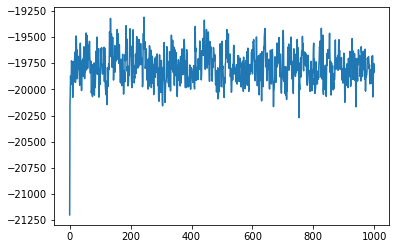

In [28]:
plt.plot(energies)
plt.show()


# Run vanilla MD on ala dipeptide at lambda = 1.0

In [29]:
with open("atp_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)
    hybrid_system = htf.hybrid_system
    hybrid_positions = htf.hybrid_positions
    box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()



In [57]:
for atom in htf.hybrid_topology.atoms:
    print(atom.index, atom)

0 ACE1-H1
1 ACE1-CH3
2 ACE1-H2
3 ACE1-H3
4 ACE1-C
5 ACE1-O
6 ALA2-N
7 ALA2-H
8 ALA2-CA
9 ALA2-HA
10 ALA2-CB
11 ALA2-HB1
12 ALA2-HB2
13 ALA2-HB3
14 ALA2-C
15 ALA2-O
1548 ALA2-HB
1549 ALA2-CG2
1550 ALA2-HG21
1551 ALA2-HG22
1552 ALA2-HG23
1553 ALA2-OG1
1554 ALA2-HG1
16 NME3-N
17 NME3-H
18 NME3-C
19 NME3-H1
20 NME3-H2
21 NME3-H3
22 HOH4-O
23 HOH4-H1
24 HOH4-H2
25 HOH5-O
26 HOH5-H1
27 HOH5-H2
28 HOH6-O
29 HOH6-H1
30 HOH6-H2
31 HOH7-O
32 HOH7-H1
33 HOH7-H2
34 HOH8-O
35 HOH8-H1
36 HOH8-H2
37 HOH9-O
38 HOH9-H1
39 HOH9-H2
40 HOH10-O
41 HOH10-H1
42 HOH10-H2
43 HOH11-O
44 HOH11-H1
45 HOH11-H2
46 HOH12-O
47 HOH12-H1
48 HOH12-H2
49 HOH13-O
50 HOH13-H1
51 HOH13-H2
52 HOH14-O
53 HOH14-H1
54 HOH14-H2
55 HOH15-O
56 HOH15-H1
57 HOH15-H2
58 HOH16-O
59 HOH16-H1
60 HOH16-H2
61 HOH17-O
62 HOH17-H1
63 HOH17-H2
64 HOH18-O
65 HOH18-H1
66 HOH18-H2
67 HOH19-O
68 HOH19-H1
69 HOH19-H2
70 HOH20-O
71 HOH20-H1
72 HOH20-H2
73 HOH21-O
74 HOH21-H1
75 HOH21-H2
76 HOH22-O
77 HOH22-H1
78 HOH22-H2
79 HOH23-O
80 HOH23-H1
81 

In [3]:
sterics_force = hybrid_system.getForce(5)
for i in range(sterics_force.getNumParticles()):
    print(i, sterics_force.getParticleParameters(i))
 

0 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.2649532787749369, 0.2649532787749369, 0.06568879999999999, 0.06568879999999999)
1 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.3399669508423535, 0.3399669508423535, 0.4577296, 0.4577296)
2 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.2649532787749369, 0.2649532787749369, 0.06568879999999999, 0.06568879999999999)
3 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.2649532787749369, 0.2649532787749369, 0.06568879999999999, 0.06568879999999999)
4 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.3399669508423535, 0.3399669508423535, 0.359824, 0.359824)
5 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.2959921901149463, 0.2959921901149463, 0.87864, 0.87864)
6 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.3249998523775958, 0.3249998523775958, 0.7112800000000001, 0.7112800000000001)
7 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.10690784617684071, 0.10690784617684071, 0.06568879999999999, 0.06568879999999999)
8 (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.3399669508423535, 0.3399669508423535, 0.4577296, 0.4577296)
9 (1.0

1220 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0)
1221 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0)
1222 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.3150752406575124, 0.3150752406575124, 0.635968, 0.635968)
1223 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0)
1224 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0)
1225 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.3150752406575124, 0.3150752406575124, 0.635968, 0.635968)
1226 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0)
1227 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0)
1228 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.3150752406575124, 0.3150752406575124, 0.635968, 0.635968)
1229 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0)
1230 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0)
1231 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.3150752406575124, 0.3150752406575124, 0.635968, 0.635968)
1232 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0)
1233 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1

In [5]:
sterics_force_og = htf._topology_proposal.new_system.getForce(3)
for i in range(sterics_force_og.getNumParticles()):
    print(i, sterics_force_og.getParticleParameters(i))
 

0 [Quantity(value=0.1123, unit=elementary charge), Quantity(value=0.2649532787749369, unit=nanometer), Quantity(value=0.06568879999999999, unit=kilojoule/mole)]
1 [Quantity(value=-0.3662, unit=elementary charge), Quantity(value=0.3399669508423535, unit=nanometer), Quantity(value=0.4577296, unit=kilojoule/mole)]
2 [Quantity(value=0.1123, unit=elementary charge), Quantity(value=0.2649532787749369, unit=nanometer), Quantity(value=0.06568879999999999, unit=kilojoule/mole)]
3 [Quantity(value=0.1123, unit=elementary charge), Quantity(value=0.2649532787749369, unit=nanometer), Quantity(value=0.06568879999999999, unit=kilojoule/mole)]
4 [Quantity(value=0.5972, unit=elementary charge), Quantity(value=0.3399669508423535, unit=nanometer), Quantity(value=0.359824, unit=kilojoule/mole)]
5 [Quantity(value=-0.5679, unit=elementary charge), Quantity(value=0.2959921901149463, unit=nanometer), Quantity(value=0.87864, unit=kilojoule/mole)]
6 [Quantity(value=-0.4157, unit=elementary charge), Quantity(valu

1360 [Quantity(value=0.417, unit=elementary charge), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
1361 [Quantity(value=-0.834, unit=elementary charge), Quantity(value=0.3150752406575124, unit=nanometer), Quantity(value=0.635968, unit=kilojoule/mole)]
1362 [Quantity(value=0.417, unit=elementary charge), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
1363 [Quantity(value=0.417, unit=elementary charge), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
1364 [Quantity(value=-0.834, unit=elementary charge), Quantity(value=0.3150752406575124, unit=nanometer), Quantity(value=0.635968, unit=kilojoule/mole)]
1365 [Quantity(value=0.417, unit=elementary charge), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
1366 [Quantity(value=0.417, unit=elementary charge), Quantity(value=1.0, unit=nanometer), Quantity(value=0.0, unit=kilojoule/mole)]
1367 [Quantity(value=-0.834, unit=

In [41]:
# nb_force = hybrid_system.getForce(7)
# for i in range(nb_force.getNumExceptions()):
#     p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
#     nb_force.setExceptionParameters(i, p1, p2, chargeProd*0, sigma, epsilon*0)
#     if sigma.value_in_unit_system(unit.md_unit_system) == 0:
#     print(i, sigma.value_in_unit_system(unit.md_unit_system))
 

In [56]:
htf._atom_classes['unique_new_atoms']


{1548, 1549, 1550, 1551, 1552, 1553, 1554}

In [58]:
# electrostatics_force = hybrid_system.getForce(4)
# sterics_force = hybrid_system.getForce(5)

# for i in [10, 1548, 1549, 1550, 1551, 1552, 1553, 1554]:
#     params = sterics_force.getParticleParameters(i)
#     params = list(params)
#     params[-1] = params[-1]*0
#     params[-2] = params[-2]*0
#     sterics_force.setParticleParameters(i, params)

#     params = electrostatics_force.getParticleParameters(i)
#     params = list(params)
#     params[-1] = params[-1]*0
#     params[-2] = params[-2]*0
#     electrostatics_force.setParticleParameters(i, params)


In [30]:
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 1
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

# print(compound_thermodynamic_state.lambda_rest_bonds)
# print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
# print(compound_thermodynamic_state.lambda_alchemical_bonds_new)
# print(compound_thermodynamic_state.lambda_alchemical_electrostatics_reciprocal)
# print(compound_thermodynamic_state.lambda_alchemical_sterics_old)
# print(compound_thermodynamic_state.lambda_alchemical_sterics_exceptions_old)
# print(compound_thermodynamic_state.lambda_alchemical_sterics_new)
# print(compound_thermodynamic_state.lambda_alchemical_sterics_exceptions_new)

In [31]:
# compound_thermodynamic_state.lambda_alchemical_electrostatics_reciprocal = 0
# compound_thermodynamic_state.lambda_alchemical_electrostatics_new = 0
# compound_thermodynamic_state.lambda_alchemical_electrostatics_exceptions_new = 0
# compound_thermodynamic_state.lambda_alchemical_sterics_new = 0
# compound_thermodynamic_state.lambda_alchemical_sterics_exceptions_new = 0


In [32]:
# Get energy
integrator = LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [33]:
for k, v in context.getParameters().items():
    print(k, v)

MonteCarloPressure 1.01325
MonteCarloTemperature 300.0
lambda_alchemical_angles_new 1.0
lambda_alchemical_angles_old 0.0
lambda_alchemical_bonds_new 1.0
lambda_alchemical_bonds_old 0.0
lambda_alchemical_electrostatics_exceptions_new 1.0
lambda_alchemical_electrostatics_exceptions_old 0.0
lambda_alchemical_electrostatics_new 1.0
lambda_alchemical_electrostatics_old 0.0
lambda_alchemical_electrostatics_reciprocal 1.0
lambda_alchemical_sterics_exceptions_new 1.0
lambda_alchemical_sterics_exceptions_old 0.0
lambda_alchemical_sterics_new 1.0
lambda_alchemical_sterics_old 0.0
lambda_alchemical_torsions_new 1.0
lambda_alchemical_torsions_old 0.0
lambda_rest_angles 1.0
lambda_rest_bonds 1.0
lambda_rest_electrostatics 1.0
lambda_rest_electrostatics_exceptions 1.0
lambda_rest_sterics 1.0
lambda_rest_sterics_exceptions 1.0
lambda_rest_torsions 1.0


In [34]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)


In [ ]:
energies, positions_old, positions_new = [], [], []

# for _ in tqdm_notebook(range(1000)):
#     integrator.step(250) 

for step in tqdm_notebook(range(250000)):
    integrator.step(1) 
    
    if step > 1000:
    
        # Get energy and positions
        state = context.getState(getEnergy=True, getPositions=True)
        energies.append(state.getPotentialEnergy().value_in_unit_system(unit.md_unit_system))
        pos = state.getPositions(asNumpy=True)
        old_pos = np.asarray(htf.old_positions(pos))
        new_pos = np.asarray(htf.new_positions(pos))
        positions_old.append(old_pos)
        positions_new.append(new_pos)


/scratch/lsftmp/4086039.tmpdir/ipykernel_62934/818673277.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm_notebook(range(250000)):


  0%|          | 0/250000 [00:00<?, ?it/s]

In [ ]:
with open("ala_lambda_1_energies.npy", "wb") as f:
    np.save(f, energies)

with open("ala_lambda_1_old.npy", "wb") as f:
    np.save(f, positions_old)

with open("ala_lambda_1_new.npy", "wb") as f:
    np.save(f, positions_new)
    

In [24]:
with open("ala_lambda_1_energies.npy", "rb") as f:
    energies = np.load(f)

with open("ala_lambda_1_old.npy", "rb") as f:
    positions_old = np.load(f)

with open("ala_lambda_1_new.npy", "rb") as f:
    positions_new = np.load(f)
    

In [65]:
htf._atom_classes['unique_old_atoms']

{11, 12, 13}

In [66]:
htf._atom_classes['unique_new_atoms']

{1557, 1558, 1559, 1560, 1561, 1562, 1563}

In [71]:
htf._atom_classes['core_atoms']

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19, 20, 21}

In [73]:
htf._rest_region

[4,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 1557,
 1558,
 1559,
 1560,
 1561,
 1562,
 1563,
 16,
 17]

In [69]:
for i in {1557, 1558, 1559, 1560, 1561, 1562, 1563}:
    print(htf._hybrid_to_new_map[i])

13
14
15
16
17
18
19


In [27]:
for i, p in enumerate(positions_old[832]):
    print(i, p)

0 [1.13244556 0.55652141 2.28663996]
1 [1.07900205 0.55184162 2.38152352]
2 [1.14033025 0.53751803 2.47048804]
3 [1.00806764 0.47122096 2.36282544]
4 [0.99862295 0.67587739 2.37895184]
5 [1.06399186 0.77622366 2.42303299]
6 [0.87201025 0.6959791  2.35896365]
7 [0.81766082 0.61102317 2.36440683]
8 [0.79702673 0.81253633 2.35865006]
9 [0.81027485 0.86085295 2.26184618]
10 [1.30564917e+26 7.51942798e+25 1.26121162e+26]
11 [-9.22637897e+25 -5.17155748e+25 -1.01902633e+26]
12 [ 3.39410124e+24  2.24396021e+24 -1.03258254e+24]
13 [ 1.12894740e+24  5.70800545e+23 -8.12762078e+22]
14 [0.81609392 0.91399081 2.4773637 ]
15 [0.80949508 0.85503738 2.59131094]
16 [0.85082855 1.03839137 2.4278299 ]
17 [0.85786114 1.07979988 2.33597742]
18 [0.89158322 1.14102202 2.52581924]
19 [0.88482796 1.23914705 2.47884217]
20 [0.80987499 1.14876232 2.59754687]
21 [0.98688678 1.14034972 2.57871328]
22 [0.55492722 1.41952702 1.35984498]
23 [0.62076201 1.36345472 1.40088151]
24 [0.51920492 1.47133732 1.43196937]
25 

423 [0.55878392 2.17585323 0.12968659]
424 [0.73946254 0.01032132 0.52658724]
425 [0.79322403 0.08381294 0.49707449]
426 [ 0.76248118 -0.06146297  0.46760017]
427 [0.89244473 1.98759211 2.25876514]
428 [0.96767704 1.96387939 2.20454222]
429 [0.82184757 2.00365808 2.19615328]
430 [1.54702671 1.88341211 0.61967255]
431 [1.55286626 1.94982732 0.5509904 ]
432 [1.47113983 1.83037212 0.5953773 ]
433 [2.18256765 0.11417126 1.49627773]
434 [2.23254705 0.07377302 1.42533861]
435 [2.24169924 0.11206541 1.57151959]
436 [2.42932701 1.76947945 2.28033408]
437 [2.48696664 1.84589492 2.28115116]
438 [2.3432856  1.80406473 2.30406282]
439 [1.32749241 1.34154441 0.92828631]
440 [1.42219241 1.34425789 0.94195616]
441 [1.31485005 1.37783424 0.84061911]
442 [2.35254719 2.29678607 0.73205192]
443 [2.38491875 2.21918414 0.77779402]
444 [2.28460324 2.33195336 0.78957757]
445 [0.41600909 0.71030759 0.53509163]
446 [0.45574226 0.63233657 0.49630872]
447 [0.3343544  0.72227912 0.48659925]
448 [1.1808086 0.06994

821 [2.52628626 1.30553988 1.54140418]
822 [2.44051475 1.28395763 1.41853675]
823 [2.43365249 0.67038118 2.45380564]
824 [2.39376154 0.59417176 2.41181571]
825 [2.38109834 0.68466082 2.53252331]
826 [1.6510179  2.40003947 1.32398156]
827 [1.7055763  2.47780624 1.31223299]
828 [1.65378618 2.38277584 1.41809119]
829 [1.08229673 1.64619139 0.38986512]
830 [1.07488426 1.61178476 0.47887948]
831 [0.99327477 1.67289524 0.36696724]
832 [1.32763149 2.24597014 1.02058989]
833 [1.37323634 2.23579047 1.10412964]
834 [1.39745945 2.26041431 0.9567327 ]
835 [0.48291499 0.95656756 0.23323234]
836 [0.51894315 0.92878282 0.31744813]
837 [0.50838492 1.04850291 0.22539067]
838 [1.04076303 0.88539918 0.98229956]
839 [1.09087568 0.92396486 1.05415865]
840 [0.95553895 0.92877727 0.98648471]
841 [1.87512812 2.18254422 0.90853166]
842 [1.9616881  2.15119097 0.93473588]
843 [1.87721784 2.18160318 0.81283911]
844 [1.7853231  2.22317416 0.2818736 ]
845 [1.87648134 2.24663352 0.26449108]
846 [1.73438587 2.2814756

1209 [0.47170689 2.04217155 1.05407389]
1210 [2.48982272 0.62268058 1.46215313]
1211 [2.53683264 0.5445552  1.43301877]
1212 [2.55552828 0.69226581 1.46042315]
1213 [2.2434655  1.94099469 1.91076932]
1214 [2.1914622  1.94022667 1.99112717]
1215 [2.18287005 1.97154095 1.84326054]
1216 [2.01943506 2.37088066 0.18706711]
1217 [2.09630423 2.40729422 0.1431638 ]
1218 [1.94503857 2.40503471 0.13745883]
1219 [0.16639804 0.37083309 1.97602643]
1220 [0.21060281 0.43208068 2.03482261]
1221 [0.13284704 0.30218956 2.03368677]
1222 [2.47924943 0.11892718 0.91689679]
1223 [2.41492357 0.08615636 0.85404319]
1224 [2.50401117 0.20503335 0.88320846]
1225 [1.57235021 1.7708683  2.38175064]
1226 [1.54300441 1.74760845 2.29365909]
1227 [1.63328627 1.70112692 2.40594268]
1228 [1.03194551 2.13266013 0.7909011 ]
1229 [1.05118656 2.21564359 0.7472451 ]
1230 [0.94507843 2.10829507 0.75892028]
1231 [1.55635806 2.06567837 0.38152625]
1232 [1.64549679 2.08874149 0.35535952]
1233 [1.50514408 2.07260488 0.30095659]


In [29]:
for i, p in enumerate(positions_new[832]):
    print(i, p)

0 [1.13244556 0.55652141 2.28663996]
1 [1.07900205 0.55184162 2.38152352]
2 [1.14033025 0.53751803 2.47048804]
3 [1.00806764 0.47122096 2.36282544]
4 [0.99862295 0.67587739 2.37895184]
5 [1.06399186 0.77622366 2.42303299]
6 [0.87201025 0.6959791  2.35896365]
7 [0.81766082 0.61102317 2.36440683]
8 [0.79702673 0.81253633 2.35865006]
9 [0.81027485 0.86085295 2.26184618]
10 [1.30564917e+26 7.51942798e+25 1.26121162e+26]
11 [0.81609392 0.91399081 2.4773637 ]
12 [0.80949508 0.85503738 2.59131094]
13 [-1.12927482e+25 -8.13404716e+24  7.35358989e+24]
14 [0.53673474 0.88842214 2.37766388]
15 [0.53140873 0.95805274 2.2939727 ]
16 [0.43442031 0.85320882 2.39080847]
17 [0.56240491 0.95406674 2.4608073 ]
18 [0.60701936 0.69202515 2.25516227]
19 [0.66658881 0.70323787 2.18071929]
20 [0.85082855 1.03839137 2.4278299 ]
21 [0.85786114 1.07979988 2.33597742]
22 [0.89158322 1.14102202 2.52581924]
23 [0.88482796 1.23914705 2.47884217]
24 [0.80987499 1.14876232 2.59754687]
25 [0.98688678 1.14034972 2.57871

421 [0.92782396 0.63257655 0.28987714]
422 [0.09706791 1.98419343 1.8023994 ]
423 [0.12827421 1.97804777 1.71211809]
424 [0.03534278 2.05734785 1.80152837]
425 [0.52631162 2.08758261 0.11190553]
426 [0.53821378 2.04055773 0.19442413]
427 [0.55878392 2.17585323 0.12968659]
428 [0.73946254 0.01032132 0.52658724]
429 [0.79322403 0.08381294 0.49707449]
430 [ 0.76248118 -0.06146297  0.46760017]
431 [0.89244473 1.98759211 2.25876514]
432 [0.96767704 1.96387939 2.20454222]
433 [0.82184757 2.00365808 2.19615328]
434 [1.54702671 1.88341211 0.61967255]
435 [1.55286626 1.94982732 0.5509904 ]
436 [1.47113983 1.83037212 0.5953773 ]
437 [2.18256765 0.11417126 1.49627773]
438 [2.23254705 0.07377302 1.42533861]
439 [2.24169924 0.11206541 1.57151959]
440 [2.42932701 1.76947945 2.28033408]
441 [2.48696664 1.84589492 2.28115116]
442 [2.3432856  1.80406473 2.30406282]
443 [1.32749241 1.34154441 0.92828631]
444 [1.42219241 1.34425789 0.94195616]
445 [1.31485005 1.37783424 0.84061911]
446 [2.35254719 2.2967

800 [2.03548705 1.39863302 1.72039537]
801 [2.08945822 1.32542412 1.69056438]
802 [1.96609367 1.35776978 1.7721358 ]
803 [0.8524357 1.1238707 1.8009931]
804 [0.85461964 1.03663085 1.84032194]
805 [0.84389877 1.18351777 1.87536827]
806 [0.09224767 1.60001699 0.42697584]
807 [0.0610547  1.53337185 0.36575703]
808 [0.13182912 1.66708419 0.3713196 ]
809 [1.23149679 2.38105335 0.39167391]
810 [1.25905424 2.29401986 0.42045023]
811 [1.31259425 2.42426283 0.36486977]
812 [0.26585873 1.39728323 2.23217298]
813 [0.18769289 1.39415134 2.17701311]
814 [0.31861045 1.32281485 2.20329332]
815 [0.81105151 2.32480163 0.35432758]
816 [0.87470489 2.35779577 0.29090872]
817 [0.82978034 2.23114299 0.36062104]
818 [0.5595599  1.32539323 2.48353714]
819 [0.6310016  1.3877073  2.47029481]
820 [0.53523342 1.29764951 2.39521485]
821 [2.44229907 2.21321337 0.44742218]
822 [2.40094551 2.28127429 0.39431935]
823 [2.46180433 2.25625923 0.5306623 ]
824 [2.47121776 1.24036064 1.49802855]
825 [2.52628626 1.30553988 1

1209 [0.08240039 2.53009602 0.59256829]
1210 [0.0371041  2.41234611 0.67624718]
1211 [0.55762205 2.01601308 1.02095836]
1212 [0.61774434 2.03423669 1.09317698]
1213 [0.47170689 2.04217155 1.05407389]
1214 [2.48982272 0.62268058 1.46215313]
1215 [2.53683264 0.5445552  1.43301877]
1216 [2.55552828 0.69226581 1.46042315]
1217 [2.2434655  1.94099469 1.91076932]
1218 [2.1914622  1.94022667 1.99112717]
1219 [2.18287005 1.97154095 1.84326054]
1220 [2.01943506 2.37088066 0.18706711]
1221 [2.09630423 2.40729422 0.1431638 ]
1222 [1.94503857 2.40503471 0.13745883]
1223 [0.16639804 0.37083309 1.97602643]
1224 [0.21060281 0.43208068 2.03482261]
1225 [0.13284704 0.30218956 2.03368677]
1226 [2.47924943 0.11892718 0.91689679]
1227 [2.41492357 0.08615636 0.85404319]
1228 [2.50401117 0.20503335 0.88320846]
1229 [1.57235021 1.7708683  2.38175064]
1230 [1.54300441 1.74760845 2.29365909]
1231 [1.63328627 1.70112692 2.40594268]
1232 [1.03194551 2.13266013 0.7909011 ]
1233 [1.05118656 2.21564359 0.7472451 ]


In [81]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom.index, atom)

0 <Atom 0 (H1) of chain 0 residue 0 (ACE)>
1 <Atom 1 (CH3) of chain 0 residue 0 (ACE)>
2 <Atom 2 (H2) of chain 0 residue 0 (ACE)>
3 <Atom 3 (H3) of chain 0 residue 0 (ACE)>
4 <Atom 4 (C) of chain 0 residue 0 (ACE)>
5 <Atom 5 (O) of chain 0 residue 0 (ACE)>
6 <Atom 6 (N) of chain 0 residue 1 (THR)>
7 <Atom 7 (H) of chain 0 residue 1 (THR)>
8 <Atom 8 (CA) of chain 0 residue 1 (THR)>
9 <Atom 9 (HA) of chain 0 residue 1 (THR)>
10 <Atom 10 (CB) of chain 0 residue 1 (THR)>
11 <Atom 11 (C) of chain 0 residue 1 (THR)>
12 <Atom 12 (O) of chain 0 residue 1 (THR)>
13 <Atom 13 (HB) of chain 0 residue 1 (THR)>
14 <Atom 14 (CG2) of chain 0 residue 1 (THR)>
15 <Atom 15 (HG21) of chain 0 residue 1 (THR)>
16 <Atom 16 (HG22) of chain 0 residue 1 (THR)>
17 <Atom 17 (HG23) of chain 0 residue 1 (THR)>
18 <Atom 18 (OG1) of chain 0 residue 1 (THR)>
19 <Atom 19 (HG1) of chain 0 residue 1 (THR)>
20 <Atom 20 (N) of chain 0 residue 2 (NME)>
21 <Atom 21 (H) of chain 0 residue 2 (NME)>
22 <Atom 22 (C) of chain 0 r

In [57]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom.index, atom)

0 <Atom 0 (H1) of chain 0 residue 0 (ACE)>
1 <Atom 1 (CH3) of chain 0 residue 0 (ACE)>
2 <Atom 2 (H2) of chain 0 residue 0 (ACE)>
3 <Atom 3 (H3) of chain 0 residue 0 (ACE)>
4 <Atom 4 (C) of chain 0 residue 0 (ACE)>
5 <Atom 5 (O) of chain 0 residue 0 (ACE)>
6 <Atom 6 (N) of chain 0 residue 1 (ALA)>
7 <Atom 7 (H) of chain 0 residue 1 (ALA)>
8 <Atom 8 (CA) of chain 0 residue 1 (ALA)>
9 <Atom 9 (HA) of chain 0 residue 1 (ALA)>
10 <Atom 10 (CB) of chain 0 residue 1 (ALA)>
11 <Atom 11 (HB1) of chain 0 residue 1 (ALA)>
12 <Atom 12 (HB2) of chain 0 residue 1 (ALA)>
13 <Atom 13 (HB3) of chain 0 residue 1 (ALA)>
14 <Atom 14 (C) of chain 0 residue 1 (ALA)>
15 <Atom 15 (O) of chain 0 residue 1 (ALA)>
16 <Atom 16 (N) of chain 0 residue 2 (NME)>
17 <Atom 17 (H) of chain 0 residue 2 (NME)>
18 <Atom 18 (C) of chain 0 residue 2 (NME)>
19 <Atom 19 (H1) of chain 0 residue 2 (NME)>
20 <Atom 20 (H2) of chain 0 residue 2 (NME)>
21 <Atom 21 (H3) of chain 0 residue 2 (NME)>
22 <Atom 22 (O) of chain 1 residue 

1526 <Atom 1526 (H1) of chain 1 residue 504 (HOH)>
1527 <Atom 1527 (H2) of chain 1 residue 504 (HOH)>
1528 <Atom 1528 (O) of chain 1 residue 505 (HOH)>
1529 <Atom 1529 (H1) of chain 1 residue 505 (HOH)>
1530 <Atom 1530 (H2) of chain 1 residue 505 (HOH)>
1531 <Atom 1531 (O) of chain 1 residue 506 (HOH)>
1532 <Atom 1532 (H1) of chain 1 residue 506 (HOH)>
1533 <Atom 1533 (H2) of chain 1 residue 506 (HOH)>
1534 <Atom 1534 (O) of chain 1 residue 507 (HOH)>
1535 <Atom 1535 (H1) of chain 1 residue 507 (HOH)>
1536 <Atom 1536 (H2) of chain 1 residue 507 (HOH)>
1537 <Atom 1537 (O) of chain 1 residue 508 (HOH)>
1538 <Atom 1538 (H1) of chain 1 residue 508 (HOH)>
1539 <Atom 1539 (H2) of chain 1 residue 508 (HOH)>
1540 <Atom 1540 (O) of chain 1 residue 509 (HOH)>
1541 <Atom 1541 (H1) of chain 1 residue 509 (HOH)>
1542 <Atom 1542 (H2) of chain 1 residue 509 (HOH)>
1543 <Atom 1543 (O) of chain 1 residue 510 (HOH)>
1544 <Atom 1544 (H1) of chain 1 residue 510 (HOH)>
1545 <Atom 1545 (H2) of chain 1 resid

In [ ]:
plt.plot(energies)
plt.show()


## Generate dcds

In [48]:
len(old)

802

In [49]:
with open("ala_lambda_1_old_20211111.npy", 'rb') as f:
    old = np.load(f)

traj = md.Trajectory(np.array(old), md.Topology.from_openmm(htf._topology_proposal.old_topology))
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
vectors = np.array([box_vectors]) 
traj.unitcell_vectors = np.repeat(vectors, 802, axis=0)
traj = traj.image_molecules()
traj.save("ala_lambda_1_old_20211111.dcd")
traj[0].save("ala_lambda_1_old_20211111.pdb")

In [50]:
with open("ala_lambda_1_new_20211111.npy", 'rb') as f:
    new = np.load(f)

traj = md.Trajectory(np.array(new), md.Topology.from_openmm(htf._topology_proposal.new_topology))
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
vectors = np.array([box_vectors]) 
traj.unitcell_vectors = np.repeat(vectors, 802, axis=0)
traj = traj.image_molecules()
traj.save("ala_lambda_1_new_20211111.dcd")
traj[0].save("ala_lambda_1_new_20211111.pdb")

In [ ]:
with open("ala_lambda_0.5_old.npy", 'rb') as f:
    old = np.load(f)

traj = md.Trajectory(np.array(old), md.Topology.from_openmm(htf._topology_proposal.old_topology))
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
vectors = np.array([box_vectors]) 
traj.unitcell_vectors = np.repeat(vectors, 1000, axis=0)
traj = traj.image_molecules()
traj.save("ala_lambda_0.5_old.dcd")
traj[0].save("ala_lambda_0.5_old.pdb")

In [ ]:
with open("ala_lambda_0.5_new.npy", 'rb') as f:
    new = np.load(f)

traj = md.Trajectory(np.array(new), md.Topology.from_openmm(htf._topology_proposal.new_topology))
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
vectors = np.array([box_vectors]) 
traj.unitcell_vectors = np.repeat(vectors, 1000, axis=0)
traj = traj.image_molecules()
traj.save("ala_lambda_0.5_new.dcd")
traj[0].save("ala_lambda_0.5_new.pdb")

In [3]:
###########################################
# IMPORTS
###########################################
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools.integrators import LangevinIntegrator
from openmmtools.constants import kB

from simtk import unit, openmm

from perses.annihilation.lambda_protocol import RESTCapableRelativeAlchemicalState, RESTCapableLambdaProtocol

import numpy as np
import itertools
import copy

import pickle
from tqdm import tqdm_notebook

from openmm import XmlSerializer


#############################################
# CONSTANTS
#############################################
temperature = 300.0 * unit.kelvin

# Set Platform
PLATFORM = openmm.Platform.getPlatformByName("CUDA")

# Load htf
with open("atp_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)
    hybrid_system = htf.hybrid_system
    hybrid_positions = htf.hybrid_positions
    box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()

with open('system.xml', 'w') as outfile:
    outfile.write(XmlSerializer.serialize(hybrid_system))
    
# Set REST T_min and T_max
T_min = temperature
T_max = 600 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 1
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

# Make context
integrator = LangevinIntegrator(temperature=temperature, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator, PLATFORM)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(temperature)
state = context.getState(getPositions=True)

with open('integrator.xml', 'w') as outfile:
    outfile.write(XmlSerializer.serialize(integrator))

with open('state.xml', 'w') as outfile:
    outfile.write(XmlSerializer.serialize(state))
    
# Print global parameters
for k, v in context.getParameters().items():
    print(k, v)

# Minimize
openmm.LocalEnergyMinimizer.minimize(context)

# Run 1 ns MD
for step in tqdm_notebook(range(250000)):
    integrator.step(1) 




    


MonteCarloPressure 1.01325
MonteCarloTemperature 300.0
lambda_alchemical_angles_new 1.0
lambda_alchemical_angles_old 0.0
lambda_alchemical_bonds_new 1.0
lambda_alchemical_bonds_old 0.0
lambda_alchemical_electrostatics_exceptions_new 1.0
lambda_alchemical_electrostatics_exceptions_old 0.0
lambda_alchemical_electrostatics_new 1.0
lambda_alchemical_electrostatics_old 0.0
lambda_alchemical_electrostatics_reciprocal 1.0
lambda_alchemical_sterics_exceptions_new 1.0
lambda_alchemical_sterics_exceptions_old 0.0
lambda_alchemical_sterics_new 1.0
lambda_alchemical_sterics_old 0.0
lambda_alchemical_torsions_new 1.0
lambda_alchemical_torsions_old 0.0
lambda_rest_angles 1.0
lambda_rest_bonds 1.0
lambda_rest_electrostatics 1.0
lambda_rest_electrostatics_exceptions 1.0
lambda_rest_sterics 1.0
lambda_rest_sterics_exceptions 1.0
lambda_rest_torsions 1.0


/scratch/lsftmp/4077412.tmpdir/ipykernel_30434/3668209419.py:81: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm_notebook(range(250000)):


  0%|          | 0/250000 [00:00<?, ?it/s]

OpenMMException: Particle coordinate is nan